Alec Dayupay - 211831 - C 

Trisha Millena - 214031 - C

Lance Santuyo - 215335 - C

Tonito Sayo - 204647 - C


We hereby attest to the truth of the following facts:

We have not discussed the Python code in my program with anyone
other than my instructor or the teaching assistants assigned to this course.

We have not used Python code obtained from another student, or
any other unauthorized source, whether modified or unmodified.

If any Python code or documentation used in my program was
obtained from another source, it has been clearly noted with citations in the
comments of my program.

In [20]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn Modules
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Optional: Advanced Models & Interpretation
try:
    import xgboost as xgb
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not available. Skipping XGBoost models.")

try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False
    print("LightGBM not available. Skipping LightGBM models.")

try:
    import shap
    HAS_SHAP = True
    shap.initjs() # Initialize Javascript for SHAP plots in notebooks
except ImportError:
    HAS_SHAP = False
    print("SHAP not available. Skipping SHAP analyses.")

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
random_state = 42 # for reproducibility


___
# Load and Prepare Data
Loading the data cleaned in `preprocessing.py`. This dataset contains only 'Released' movies with non-zero values for key financial and engagement metrics.

In [21]:
df = pd.read_csv("output/cleaned_movie_released_nonzero.csv", index_col=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10464 entries, 0 to 10463
Data columns (total 52 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   title                                          10464 non-null  object 
 1   vote_average                                   10464 non-null  float64
 2   vote_count                                     10464 non-null  int64  
 3   status                                         10464 non-null  object 
 4   release_date                                   10343 non-null  object 
 5   revenue                                        10464 non-null  int64  
 6   runtime                                        10464 non-null  int64  
 7   adult                                          10464 non-null  int64  
 8   budget                                         10464 non-null  int64  
 9   original_language                              104

___
# Data Cleaning & Filtering 

In [22]:
# Drop rows where release_date is null (should have been handled, but double-check)
df = df.dropna(subset=['release_date']).reset_index(drop=True)

# Ensure runtime is reasonable (e.g., >= 15 minutes)
df = df[(df['runtime'] >= 15) & (df['runtime'] < 400)].reset_index(drop=True)

In [23]:
# Address Potential Data Entry Errors (Budget/Revenue Scale) 
# Filter out entries where budget or revenue seems unrealistically low (e.g., < 1000)
# or where the ratio between them is extremely large, suggesting unit errors.
min_value_threshold = 1000
max_scale_mismatch = 10000

filtered_check = df[["title", "revenue", "budget"]].copy()
filtered_check['scale_mismatch'] = (df['revenue'] / df['budget']).fillna(0).replace(np.inf, 0)
# Handle cases where budget > revenue
filtered_check['scale_mismatch'] = filtered_check['scale_mismatch'].apply(lambda x: x if x >= 1 else (1/x if x > 0 else 0))

to_drop_indices = df[
    (df['revenue'] < min_value_threshold) |
    (df['budget'] < min_value_threshold) |
    (filtered_check['scale_mismatch'] >= max_scale_mismatch)
].index

In [24]:
if not to_drop_indices.empty:
    print(f"Dropping {len(to_drop_indices)} entries due to potential budget/revenue data errors.")
    print("Examples being dropped:")
    print(df.loc[to_drop_indices, ['title', 'budget', 'revenue']].head())
    df = df.drop(index=to_drop_indices).reset_index(drop=True)

Dropping 309 entries due to potential budget/revenue data errors.
Examples being dropped:
                                             title   budget  revenue
4075      French Fried Vacation 3: Friends Forever       35       84
5070                                   Housesitter       26       94
5260                                 Cross of Iron  6000000      201
5654                                         Ben X  1500000       27
5669  City Slickers II: The Legend of Curly's Gold       40       43


___
# Feature Engineering

In [25]:
# Calculate Return on Investment (ROI)
# Using a small epsilon to avoid division by zero if budget is somehow still 0
epsilon = 1
df['roi'] = (df['revenue'] - df['budget']) / (df['budget'] + epsilon)

In [26]:
# # Genre count
# genre_cols = [col for col in df.columns if col.startswith('genre_')]
# df['genre_count'] = df[genre_cols].sum(axis=1)

In [27]:
all_seasons = df['release_season'].unique()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
season_encoded = encoder.fit_transform(df[['release_season']])

In [28]:
# Create column names for the encoded features
season_cols = [f'season_{season}' for season in encoder.categories_[0]]

# Add encoded columns to dataframe
season_df = pd.DataFrame(season_encoded, columns=season_cols, index=df.index)
df = pd.concat([df, season_df], axis=1)

In [29]:
df.head()

,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,original_language,original_title,overview,popularity,keywords,release_year,release_quarter,release_season,release_month,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,production_companies_Warner_Bros._Pictures,production_companies_BBC,production_companies_Evil_Angel,production_companies_Columbia_Pictures,production_companies_Metro-Goldwyn-Mayer,production_countries_United_States_of_America,production_countries_France,production_countries_Japan,production_countries_Germany,production_countries_United_Kingdom,spoken_languages_English,spoken_languages_French,spoken_languages_Spanish,spoken_languages_Japanese,spoken_languages_German,roi,season_Fall,season_Spring,season_Summer,season_Winter
0,Inception,8.364,34495,Released,2010-07-15,825532764,148,0,160000000,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,"rescue, mission, dream, airplane, paris, franc...",2010,3,Summer,7,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,0,1,0,4.159580,0.0,0.0,1.0,0.0
1,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,0,165000000,en,Interstellar,The adventures of a group of explorers who mak...,140.241,"rescue, future, spacecraft, race against time,...",2014,4,Fall,11,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,3.252904,1.0,0.0,0.0,0.0
2,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,0,185000000,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,"joker, sadism, chaos, secret identity, crime f...",2008,3,Summer,7,1,0,0,0,1,0,1,...,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,4.430046,0.0,0.0,1.0,0.0
3,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,0,237000000,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,"future, society, culture clash, space travel, ...",2009,4,Winter,12,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,11.336312,0.0,0.0,0.0,1.0
4,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,0,220000000,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,"new york city, superhero, shield, based on com...",2012,2,Spring,4,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,5.903707,0.0,1.0,0.0,0.0


# ## 2. Exploratory Data Analysis (EDA) & Preprocessing for Modeling

# Analyze distributions and correlations to understand data properties and inform modeling choices.

In [30]:
# Define Column Groups
numerical_cols_raw = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'popularity', 'roi']
categorical_cols = []
encoded_genre_cols = [col for col in df.columns if col.startswith('genre_')]
encoded_other_cols = [col for col in df.columns if col.startswith(('production_companies_', 'production_countries_', 'spoken_languages_', 'season_'))]
time_features = ['release_year', 'release_quarter', 'release_month'] # genre_count is numerical

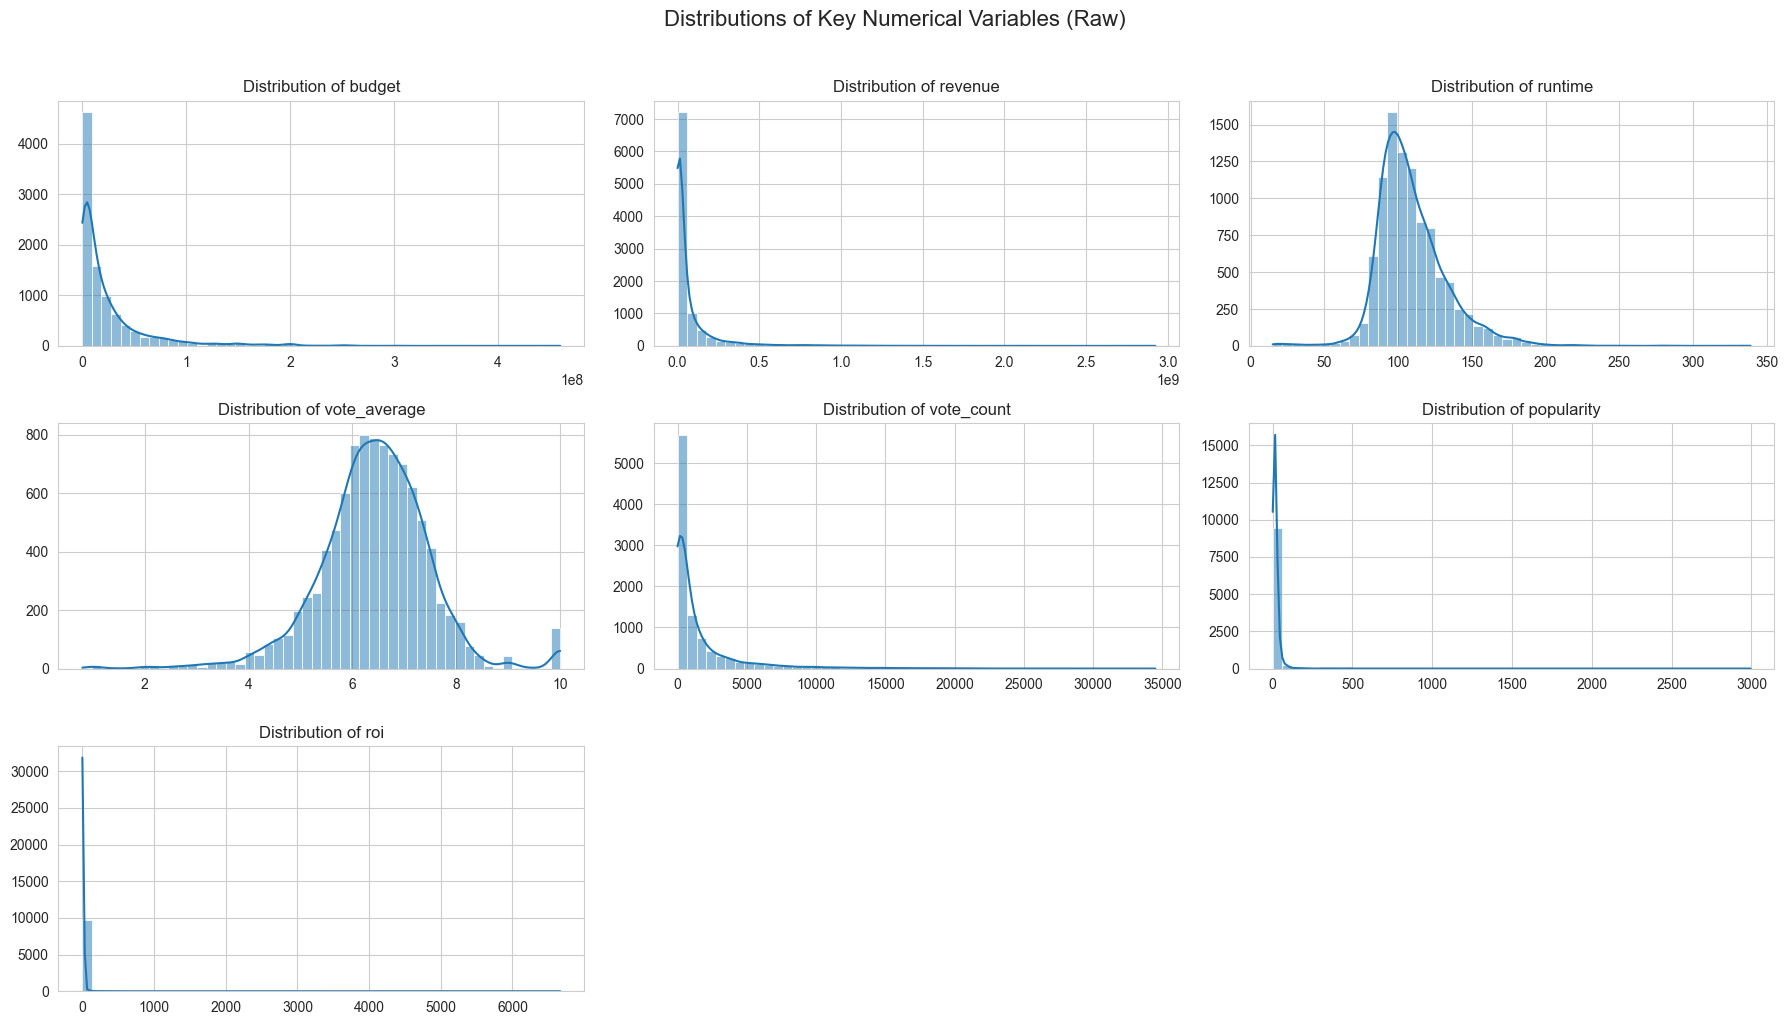

In [31]:
# Distribution Analysis (Raw)
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols_raw):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel('')
    plt.ylabel('')
plt.suptitle('Distributions of Key Numerical Variables (Raw)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [32]:
# Identify columns needing transformation
cols_to_log = ['budget', 'revenue', 'vote_count', 'popularity', 'roi']

In [33]:
# Log Transformation & Scaling
df_processed = df.copy()
numerical_cols_log = []

for col in cols_to_log:
    # Check for non-positive values before log transforming ROI
    if col == 'roi':
         # Shift ROI to be positive before log1p. Add min value + epsilon
         min_roi = df_processed[col].min()
         if min_roi <= 0:
             df_processed[f'{col}_log'] = np.log1p(df_processed[col] - min_roi + 1e-6) # Shift and add small epsilon
             print(f"Applied log1p to shifted ROI (min shifted to > 0)")
         else:
              df_processed[f'{col}_log'] = np.log1p(df_processed[col])
    else:
         df_processed[f'{col}_log'] = np.log1p(df_processed[col])

    numerical_cols_log.append(f'{col}_log')
    print(f"Log-transformed '{col}' -> '{col}_log'")

Log-transformed 'budget' -> 'budget_log'
Log-transformed 'revenue' -> 'revenue_log'
Log-transformed 'vote_count' -> 'vote_count_log'
Log-transformed 'popularity' -> 'popularity_log'
Applied log1p to shifted ROI (min shifted to > 0)
Log-transformed 'roi' -> 'roi_log'


In [34]:
# Keep untransformed versions of non-skewed numerics needed for modeling
numerical_cols_final = numerical_cols_log + ['runtime', 'vote_average'] # Use log versions + others


--- Log-Transformed Numerical Distributions ---


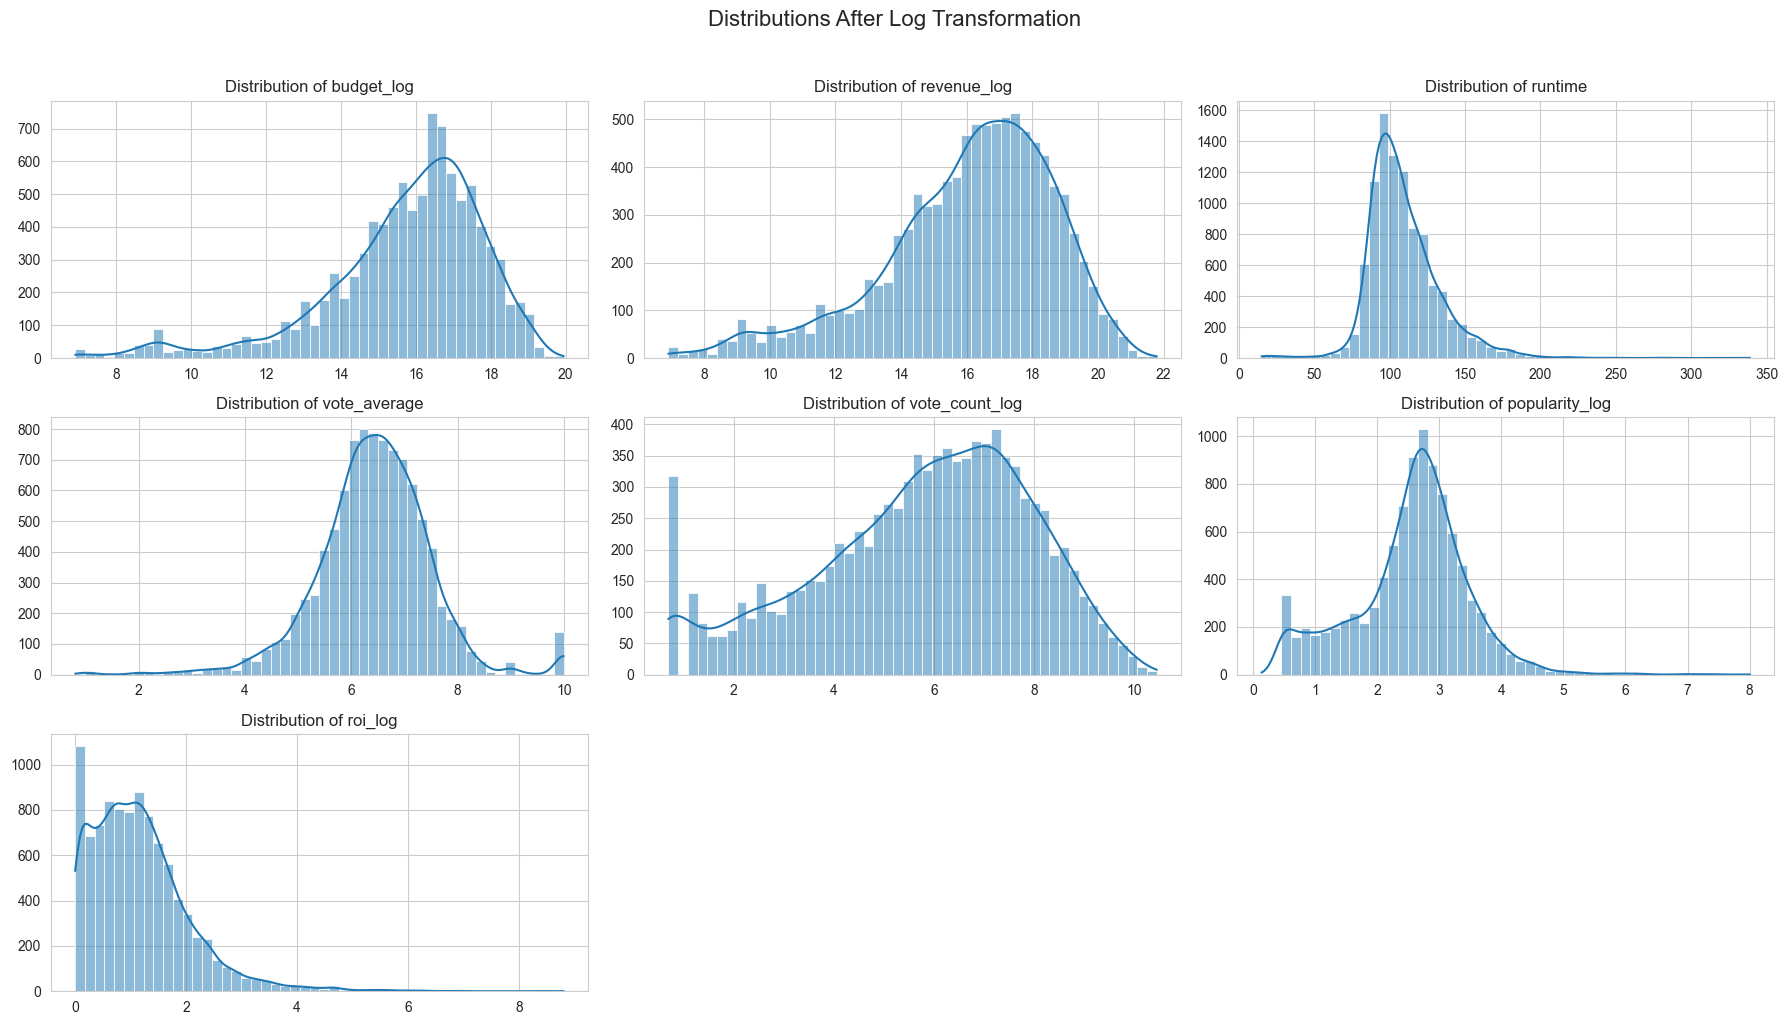

In [35]:
# Distribution Analysis (Log-Transformed)
print("\n--- Log-Transformed Numerical Distributions ---")
plt.figure(figsize=(18, 10))
plot_cols = numerical_cols_log[:2] + ['runtime', 'vote_average'] + numerical_cols_log[2:]# Include non-log cols for comparison
for i, col in enumerate(plot_cols):
     if col in df_processed.columns: # Check if column exists (e.g., roi_log might fail if all ROI <= -1)
        plt.subplot(3, 3, i+1)
        sns.histplot(df_processed[col], kde=True, bins=50)
        plt.title(f'Distribution of {col}')
        plt.xlabel('')
        plt.ylabel('')
plt.suptitle('Distributions After Log Transformation', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


--- Correlation Matrix (Log-Transformed) ---


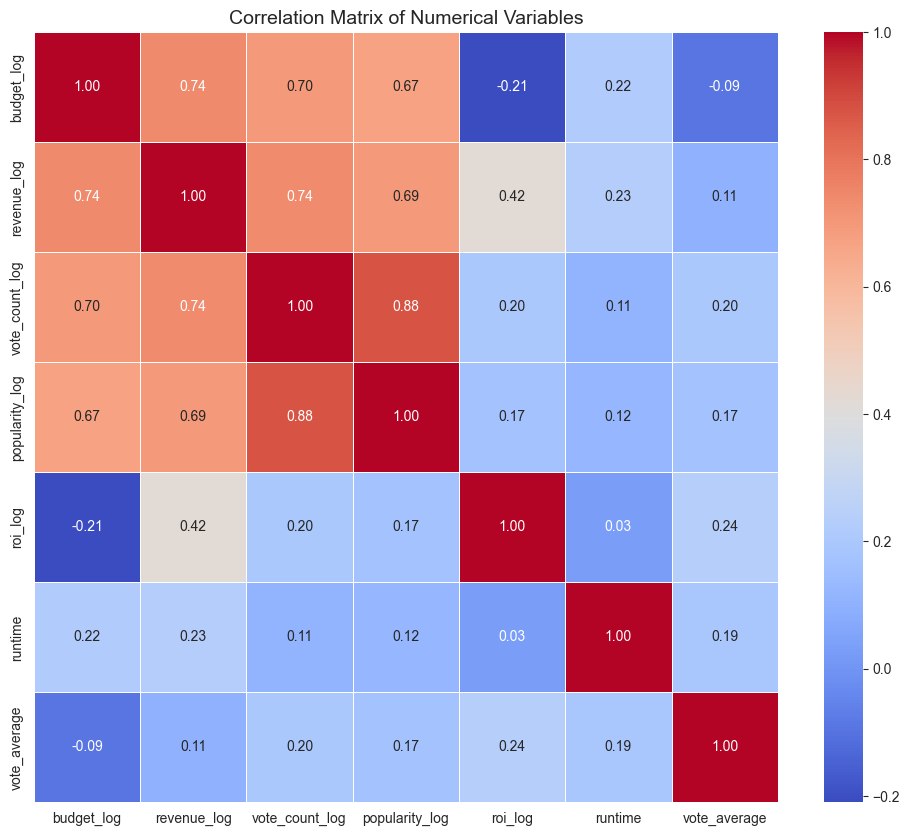


--- Descriptive Analysis for Key Goals ---


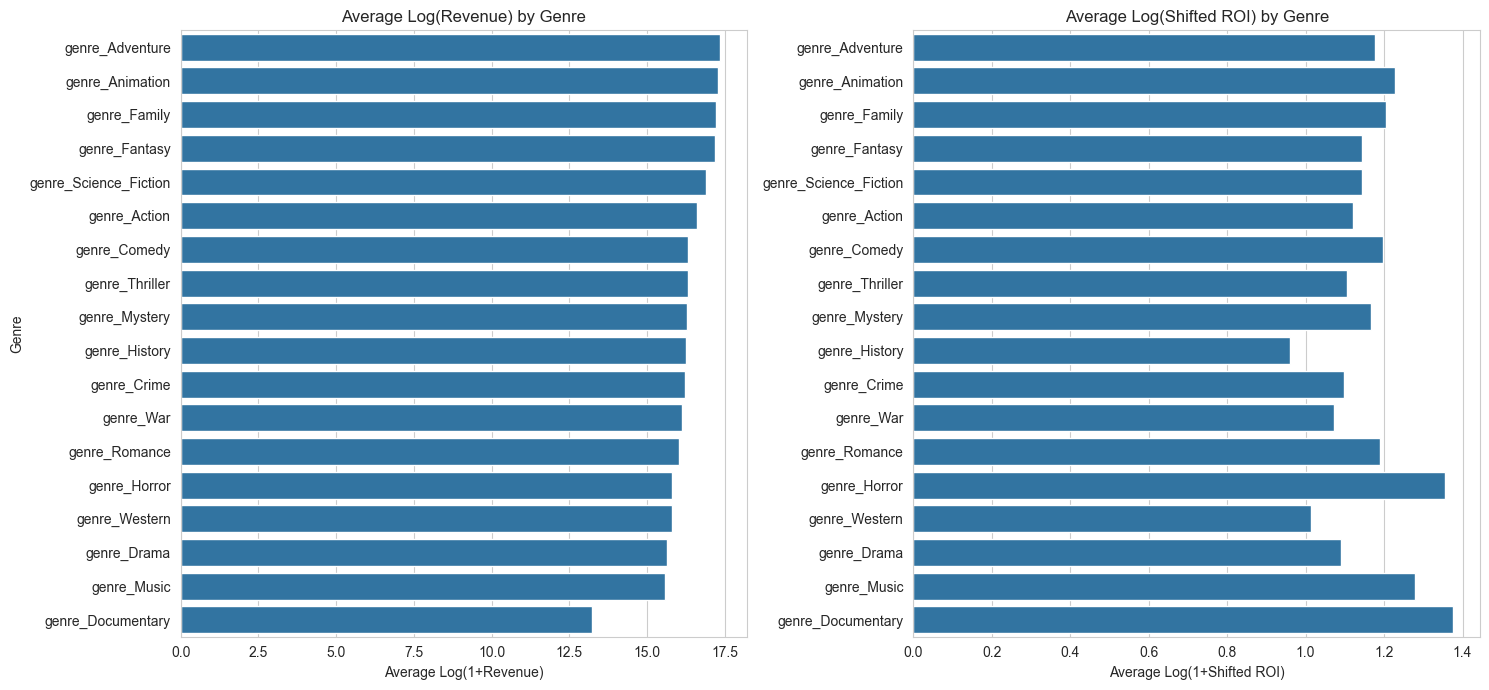

Top 5 Genres by Average Log(Revenue):
genre_Adventure          17.360243
genre_Animation          17.297066
genre_Family             17.206205
genre_Fantasy            17.191489
genre_Science_Fiction    16.893747
Name: Avg_Revenue_Log, dtype: float64


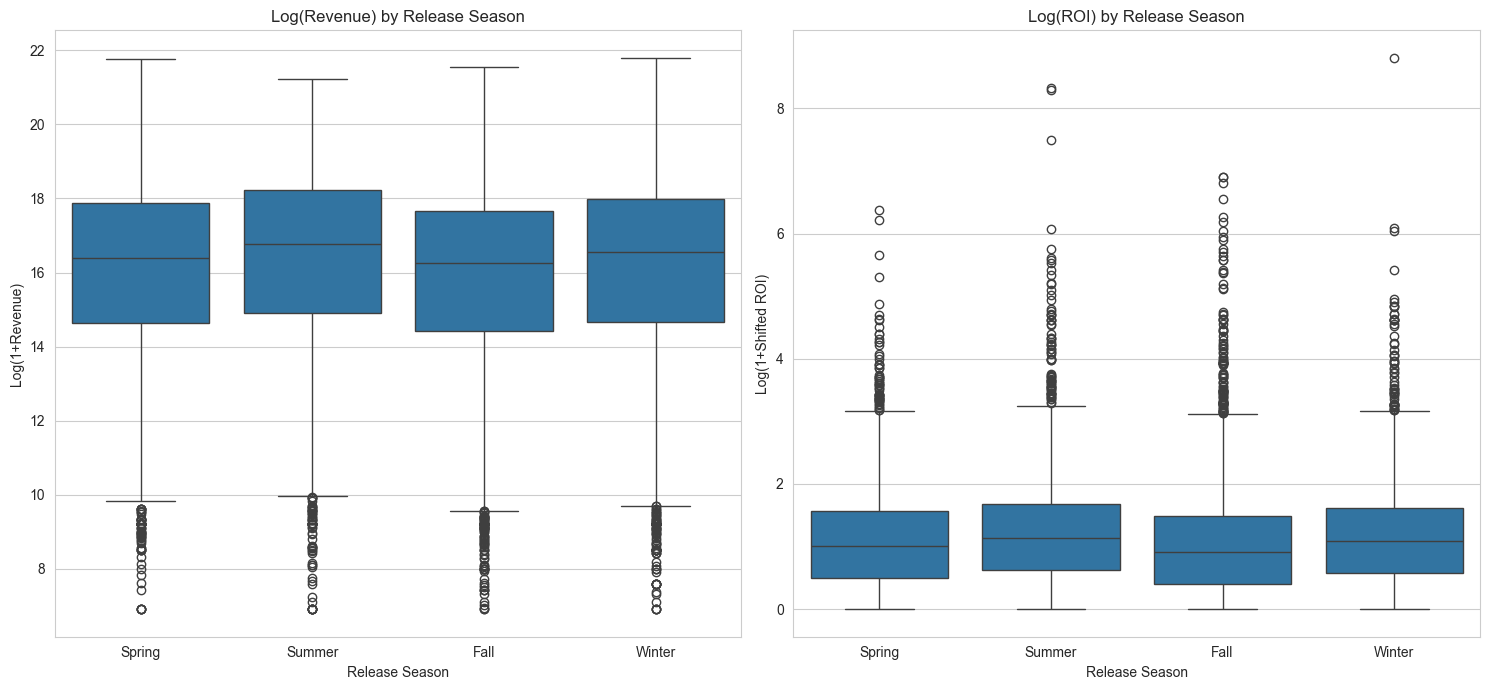

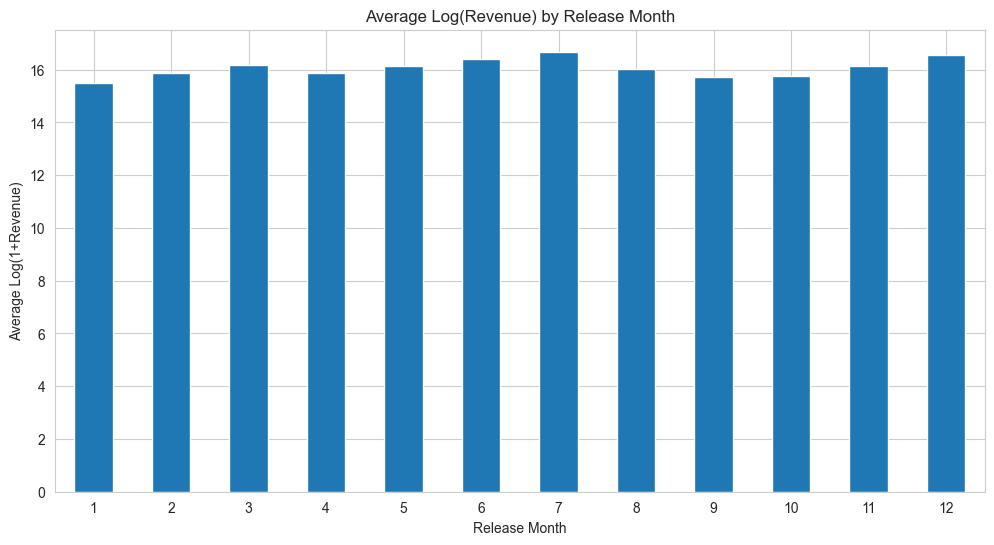

In [36]:
# --- Correlation Analysis (Log-Transformed) ---
print("\n--- Correlation Matrix (Log-Transformed) ---")
plt.figure(figsize=(12, 10))
correlation_matrix = df_processed[numerical_cols_final].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables', fontsize=14)
plt.show()

# --- Descriptive Analysis for Goals ---
print("\n--- Descriptive Analysis for Key Goals ---")

# Genre vs. Revenue/ROI
genre_analysis_cols = [col for col in encoded_genre_cols if df_processed[col].sum() > 50] # Analyze genres with min 50 movies
genre_perf = {}
for genre in genre_analysis_cols:
     genre_perf[genre] = {
         'Avg_Revenue_Log': df_processed.loc[df_processed[genre] == 1, 'revenue_log'].mean(),
         'Avg_ROI_Log': df_processed.loc[df_processed[genre] == 1, 'roi_log'].mean(),
         'Count': df_processed[genre].sum()
     }
genre_perf_df = pd.DataFrame(genre_perf).T.sort_values('Avg_Revenue_Log', ascending=False)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.barplot(x=genre_perf_df['Avg_Revenue_Log'], y=genre_perf_df.index)
plt.title('Average Log(Revenue) by Genre')
plt.xlabel('Average Log(1+Revenue)')
plt.ylabel('Genre')

plt.subplot(1, 2, 2)
sns.barplot(x=genre_perf_df['Avg_ROI_Log'], y=genre_perf_df.index)
plt.title('Average Log(Shifted ROI) by Genre')
plt.xlabel('Average Log(1+Shifted ROI)')
plt.ylabel('')
plt.tight_layout()
plt.show()
print("Top 5 Genres by Average Log(Revenue):")
print(genre_perf_df['Avg_Revenue_Log'].head())


# Release Timing vs. Revenue/ROI
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_processed, x='release_season', y='revenue_log', order=['Spring', 'Summer', 'Fall', 'Winter'])
plt.title('Log(Revenue) by Release Season')
plt.xlabel('Release Season')
plt.ylabel('Log(1+Revenue)')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_processed, x='release_season', y='roi_log', order=['Spring', 'Summer', 'Fall', 'Winter'])
plt.title('Log(ROI) by Release Season')
plt.xlabel('Release Season')
plt.ylabel('Log(1+Shifted ROI)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
df_processed.groupby('release_month')['revenue_log'].mean().plot(kind='bar')
plt.title('Average Log(Revenue) by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Log(1+Revenue)')
plt.xticks(rotation=0)
plt.show()



# 3. Define Features (X) and Targets (y)

 We will primarily use the log-transformed numerical features where appropriate, as they are less skewed.
 The target variables will also be their log-transformed versions for metrics like revenue, popularity, roi, and vote_count. `vote_average` will be predicted directly.

In [37]:
# --- Define Features ---
# Use log-transformed budget, keep original runtime, vote_average
numeric_features_model = numerical_cols_log + ['runtime'] # Exclude vote_average as it's often a target
categorical_features_model = []
binary_features_model = encoded_genre_cols + encoded_other_cols + ['adult'] # Include 'adult'
time_features_model = ['release_year', 'release_quarter', 'release_month']

all_features = numeric_features_model + categorical_features_model + binary_features_model + time_features_model

# Ensure no target columns are accidentally included in features
potential_targets = ['revenue', 'revenue_log', 'popularity', 'popularity_log',
                     'vote_count', 'vote_count_log', 'vote_average', 'roi', 'roi_log',
                     'title', 'original_title', 'overview', 'tagline', 'status', 'release_date'] # Add other text/ID cols dropped earlier

X_cols = [col for col in all_features if col in df_processed.columns and col not in potential_targets]

# Separate features (X) and targets (y)
X = df_processed[X_cols]
print(f"Feature matrix X shape: {X.shape}")
print(f"Columns in X: {X.columns.tolist()}")

# --- Define Targets ---
targets = {
    'revenue_log': df_processed['revenue_log'],
    'popularity_log': df_processed['popularity_log'],
    'vote_count_log': df_processed['vote_count_log'],
    'vote_average': df_processed['vote_average'], # Predict directly
    'roi_log': df_processed['roi_log']
}

# Check for NaNs in target variables
for name, y_data in targets.items():
    if y_data.isnull().any():
        print(f"Warning: Target '{name}' contains NaN values. Count: {y_data.isnull().sum()}")
        # Optional: Handle NaNs, e.g., by dropping rows where target is NaN
        # valid_indices = y_data.dropna().index
        # X = X.loc[valid_indices]
        # targets[name] = y_data.loc[valid_indices]


Feature matrix X shape: (9720, 44)
Columns in X: ['budget_log', 'runtime', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science_Fiction', 'genre_TV_Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'production_companies_Warner_Bros._Pictures', 'production_companies_BBC', 'production_companies_Evil_Angel', 'production_companies_Columbia_Pictures', 'production_companies_Metro-Goldwyn-Mayer', 'production_countries_United_States_of_America', 'production_countries_France', 'production_countries_Japan', 'production_countries_Germany', 'production_countries_United_Kingdom', 'spoken_languages_English', 'spoken_languages_French', 'spoken_languages_Spanish', 'spoken_languages_Japanese', 'spoken_languages_German', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'adult', 'release

# 4. Preprocessing Pipeline & Train-Test Split

Create a pipeline to handle scaling of numerical features and one-hot encoding of categorical features.
Then, split the data into training and testing sets.

In [38]:
numeric_cols_in_X = [col for col in numeric_features_model if col in X.columns]
categorical_cols_in_X = [col for col in categorical_features_model if col in X.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols_in_X)
    ],
    remainder='passthrough'
)

In [46]:
numeric_cols_in_X

['budget_log', 'runtime']

In [39]:
# --- Train-Test Split ---
target_to_model = 'revenue_log' # Example target
y = targets[target_to_model]

# Drop rows in X and y where y is NaN (if any)
valid_indices = y.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]
print(f"Shape after handling NaNs in target '{target_to_model}': X={X.shape}, y={y.shape}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Shape after handling NaNs in target 'revenue_log': X=(9720, 44), y=(9720,)
Training set size: 7776
Test set size: 1944


# ## 5. Model Training & Hyperparameter Tuning

# Train various regression models using Pipelines and tune hyperparameters using GridSearchCV.

In [40]:
# --- Define Models ---
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=random_state),
    'Lasso': Lasso(random_state=random_state),  
    'Random Forest': RandomForestRegressor(random_state=random_state, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=random_state)
}

if HAS_XGB:
    models['XGBoost'] = XGBRegressor(random_state=random_state, n_jobs=-1)
if HAS_LGBM:
    models['LightGBM'] = LGBMRegressor(random_state=random_state, n_jobs=-1, verbosity=-1)

# --- Define Hyperparameter Grids (Example for key models) ---
param_grids = {
    'Ridge': {
        'model__alpha': [0.1, 1.0, 10.0, 100.0]
    },
    'Lasso': {
        'model__alpha': [0.001, 0.01, 0.1, 1.0]
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None],
        'model__min_samples_leaf': [1, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5]
    },
     'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5],
        'model__gamma': [0, 0.1]
     } if HAS_XGB else {},
     'LightGBM': {
         'model__n_estimators': [100, 300],
         'model__learning_rate': [0.05, 0.1],
         'model__num_leaves': [31, 50],
         'model__max_depth': [-1, 10]
     } if HAS_LGBM else {}
}

In [41]:
# --- Define Features ---
# (Assuming X is already defined correctly as before)
print(f"Feature matrix X initial shape: {X.shape}")

# --- Define Targets ---
targets = {
    'revenue_log': df_processed['revenue_log'],
    'popularity_log': df_processed['popularity_log'],
    'vote_count_log': df_processed['vote_count_log'],
    'vote_average': df_processed['vote_average'], # Predict directly
    'roi_log': df_processed['roi_log']
}
print(f"Targets to process: {list(targets.keys())}")

# --- Storage for Overall Results ---
all_results = {}
all_best_estimators = {}
best_model_per_target = {}
test_sets_per_target = {} # Store X_test, y_test for SHAP later

Feature matrix X initial shape: (9720, 44)
Targets to process: ['revenue_log', 'popularity_log', 'vote_count_log', 'vote_average', 'roi_log']



==================== Processing Target: revenue_log ====================
  Target 'revenue_log' has no NaN values.
  Shape after handling NaNs for 'revenue_log': X=(9720, 44), y=(9720,)
  Training set size: 7776, Test set size: 1944

  --- Training and Tuning Models for Target: revenue_log ---
    Processing model: Linear Regression
      CV R² (no tuning): 0.5895
      Linear Regression -> Test R²: 0.5718, Test MAE: 1.2527, Test RMSE: 1.7164
    Processing model: Ridge
      Best CV R²: 0.5897
      Best Params: {'model__alpha': 10.0}
      Ridge -> Test R²: 0.5723, Test MAE: 1.2523, Test RMSE: 1.7156
    Processing model: Lasso
      Best CV R²: 0.5898
      Best Params: {'model__alpha': 0.001}
      Lasso -> Test R²: 0.5722, Test MAE: 1.2519, Test RMSE: 1.7157
    Processing model: Random Forest
      Best CV R²: 0.6201
      Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__n_estimators': 200}
      Random Forest -> Test R²: 0.6026, Test MAE: 1.1914, Test

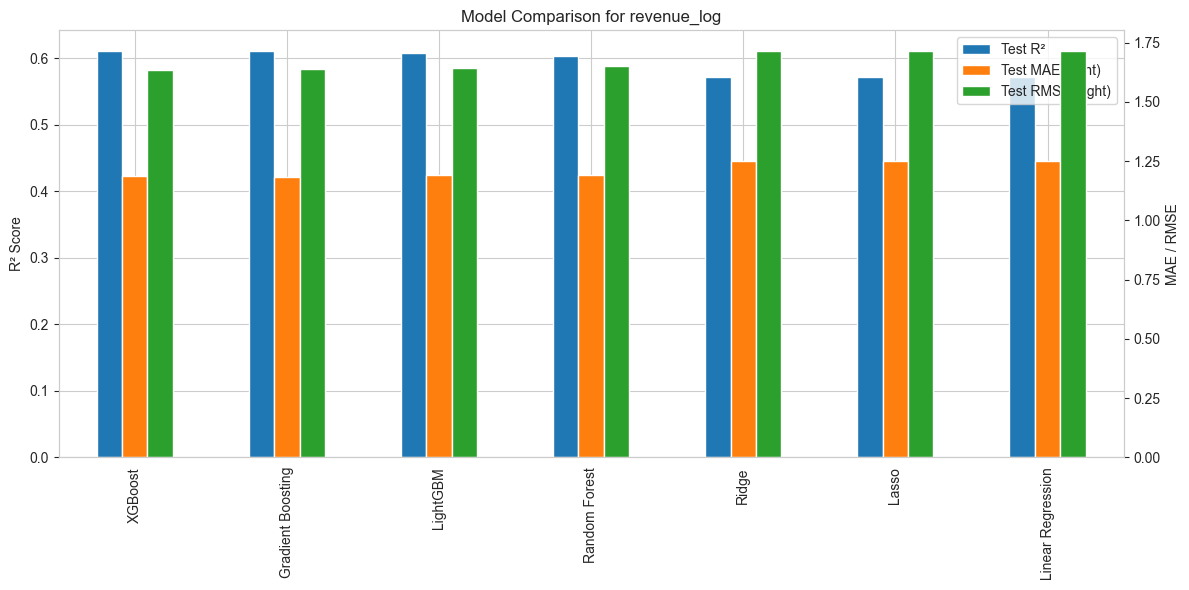

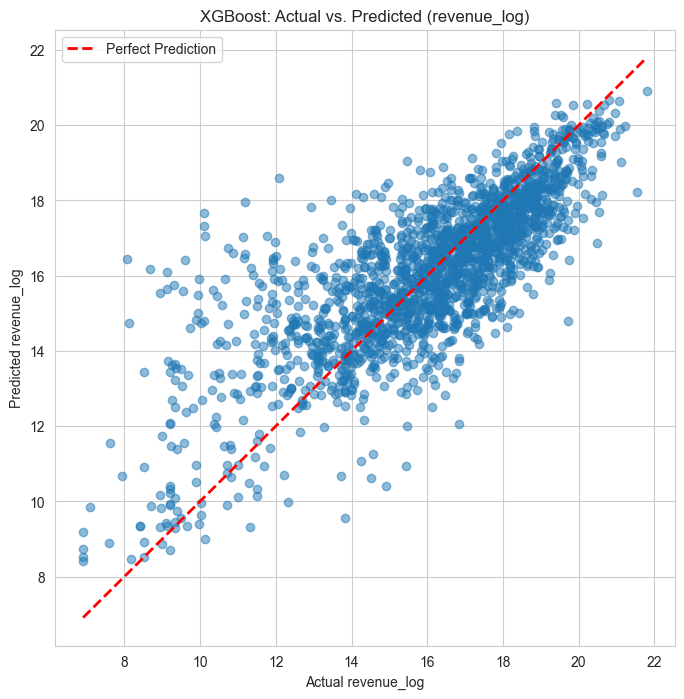


==================== Processing Target: popularity_log ====================
  Target 'popularity_log' has no NaN values.
  Shape after handling NaNs for 'popularity_log': X=(9720, 44), y=(9720,)
  Training set size: 7776, Test set size: 1944

  --- Training and Tuning Models for Target: popularity_log ---
    Processing model: Linear Regression
      CV R² (no tuning): 0.5551
      Linear Regression -> Test R²: 0.5659, Test MAE: 0.4410, Test RMSE: 0.6003
    Processing model: Ridge
      Best CV R²: 0.5553
      Best Params: {'model__alpha': 10.0}
      Ridge -> Test R²: 0.5665, Test MAE: 0.4409, Test RMSE: 0.5999
    Processing model: Lasso
      Best CV R²: 0.5548
      Best Params: {'model__alpha': 0.001}
      Lasso -> Test R²: 0.5661, Test MAE: 0.4409, Test RMSE: 0.6002
    Processing model: Random Forest
      Best CV R²: 0.6143
      Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
      Random Forest -> Test R²: 0.6286, Test MAE: 

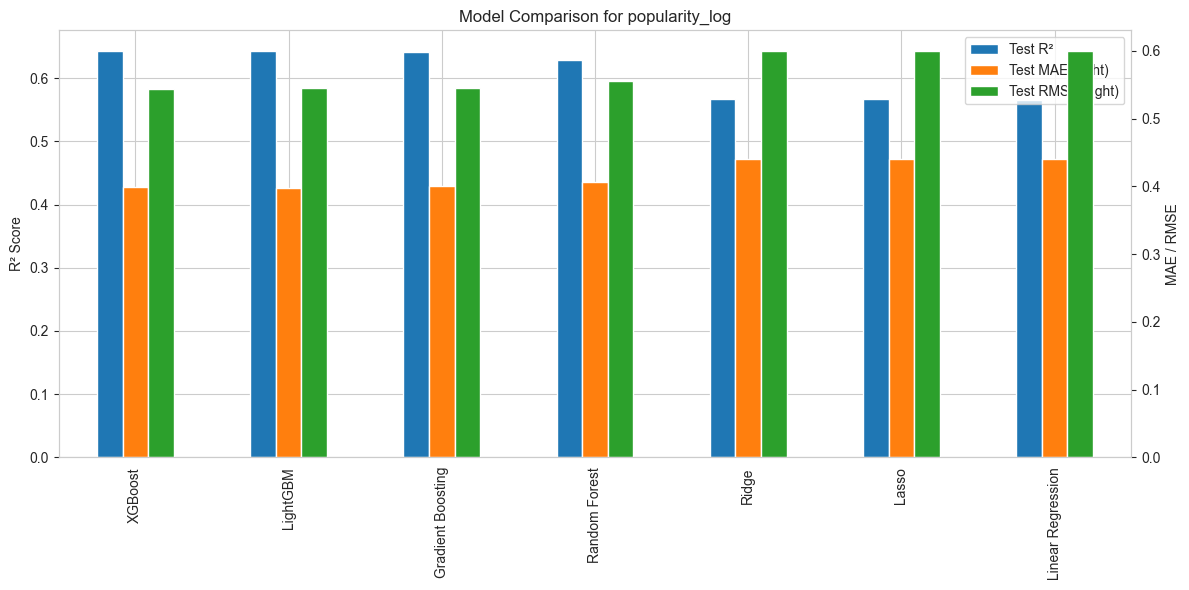

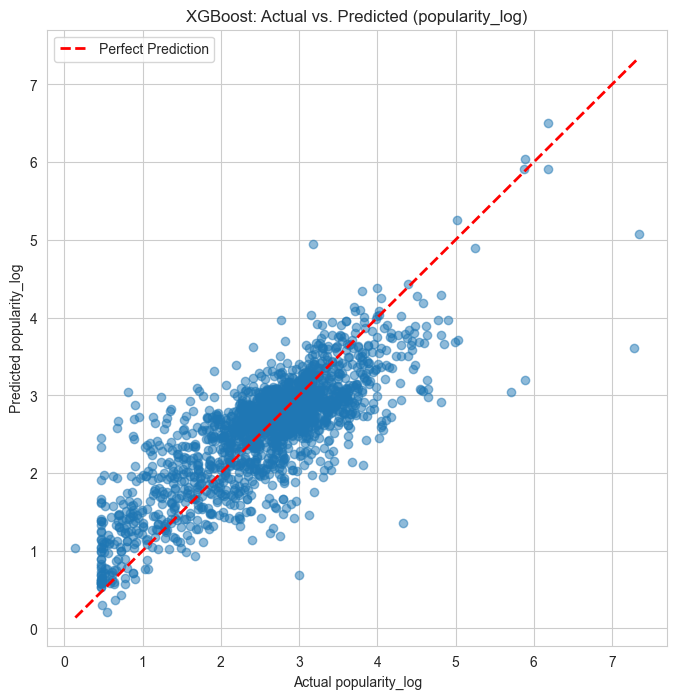


==================== Processing Target: vote_count_log ====================
  Target 'vote_count_log' has no NaN values.
  Shape after handling NaNs for 'vote_count_log': X=(9720, 44), y=(9720,)
  Training set size: 7776, Test set size: 1944

  --- Training and Tuning Models for Target: vote_count_log ---
    Processing model: Linear Regression
      CV R² (no tuning): 0.5867
      Linear Regression -> Test R²: 0.5953, Test MAE: 1.1032, Test RMSE: 1.3970
    Processing model: Ridge
      Best CV R²: 0.5870
      Best Params: {'model__alpha': 10.0}
      Ridge -> Test R²: 0.5948, Test MAE: 1.1041, Test RMSE: 1.3979
    Processing model: Lasso
      Best CV R²: 0.5869
      Best Params: {'model__alpha': 0.001}
      Lasso -> Test R²: 0.5939, Test MAE: 1.1053, Test RMSE: 1.3994
    Processing model: Random Forest
      Best CV R²: 0.6306
      Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
      Random Forest -> Test R²: 0.6403, Test MAE: 

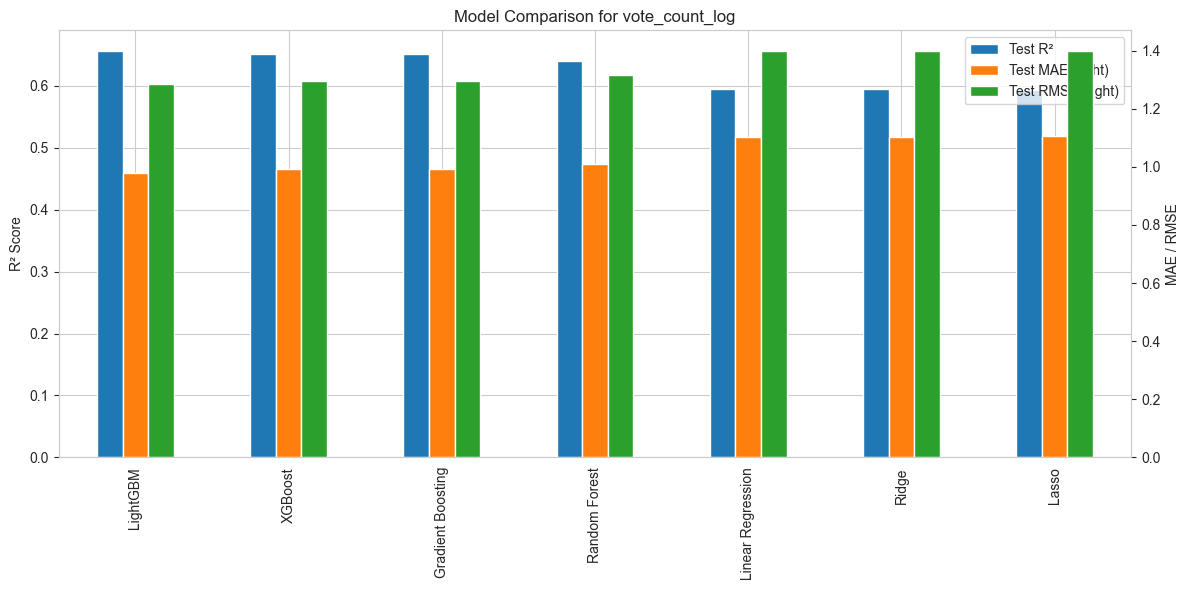

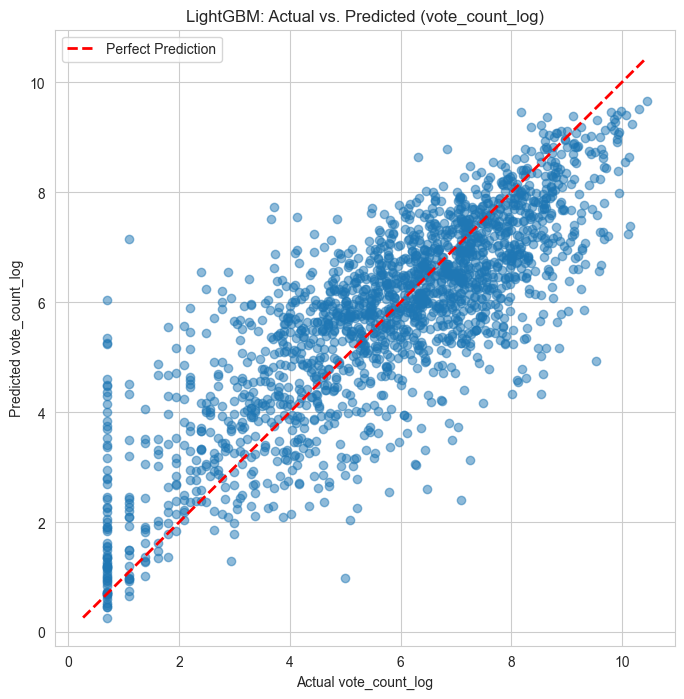


==================== Processing Target: vote_average ====================
  Target 'vote_average' has no NaN values.
  Shape after handling NaNs for 'vote_average': X=(9720, 44), y=(9720,)
  Training set size: 7776, Test set size: 1944

  --- Training and Tuning Models for Target: vote_average ---
    Processing model: Linear Regression
      CV R² (no tuning): 0.1367
      Linear Regression -> Test R²: 0.1317, Test MAE: 0.7080, Test RMSE: 1.0049
    Processing model: Ridge
      Best CV R²: 0.1368
      Best Params: {'model__alpha': 1.0}
      Ridge -> Test R²: 0.1319, Test MAE: 0.7079, Test RMSE: 1.0048
    Processing model: Lasso
      Best CV R²: 0.1367
      Best Params: {'model__alpha': 0.001}
      Lasso -> Test R²: 0.1313, Test MAE: 0.7072, Test RMSE: 1.0052
    Processing model: Random Forest
      Best CV R²: 0.2282
      Best Params: {'model__max_depth': 20, 'model__min_samples_leaf': 5, 'model__n_estimators': 200}
      Random Forest -> Test R²: 0.2620, Test MAE: 0.6680, T

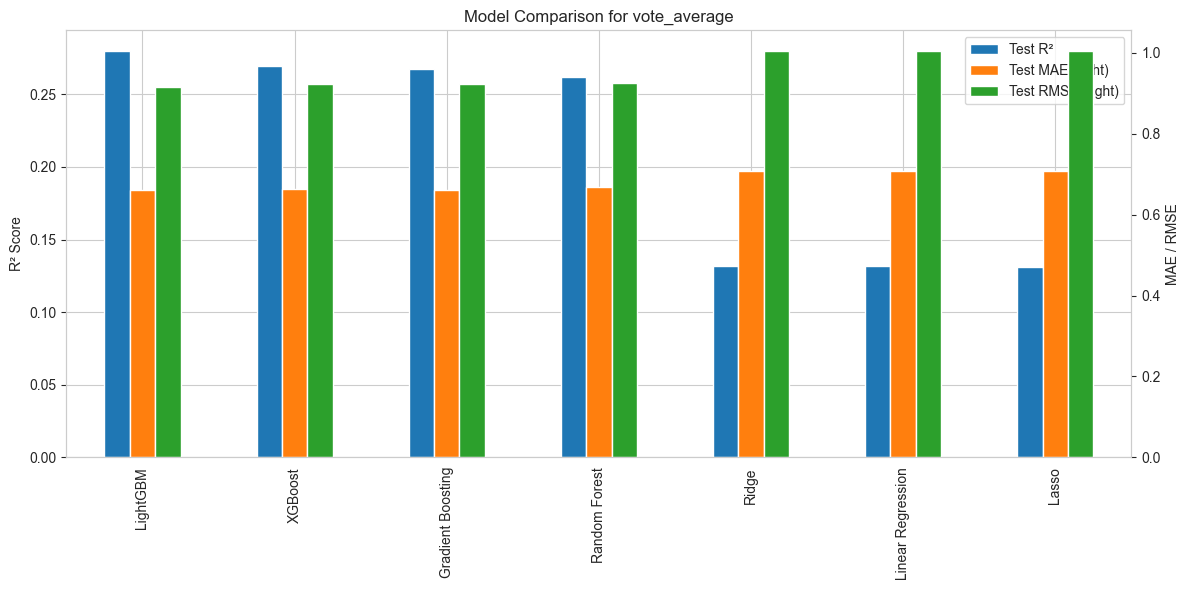

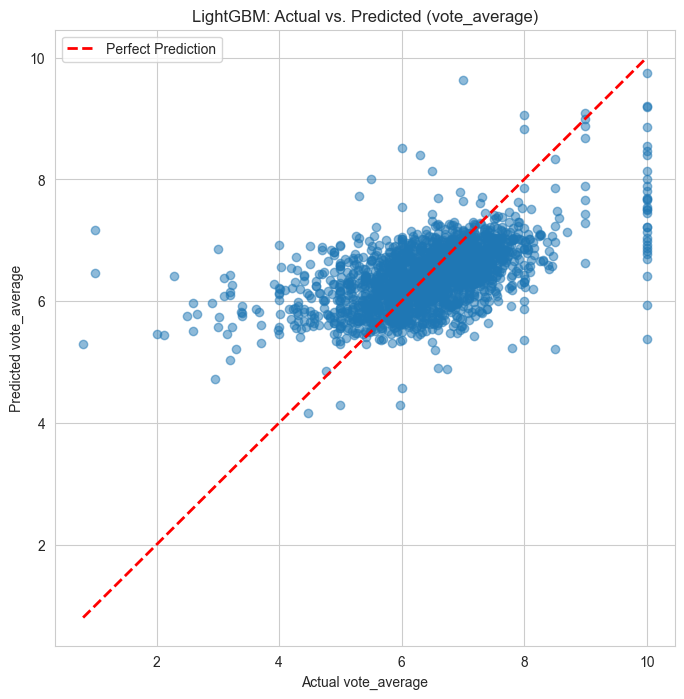


==================== Processing Target: roi_log ====================
  Target 'roi_log' has no NaN values.
  Shape after handling NaNs for 'roi_log': X=(9720, 44), y=(9720,)
  Training set size: 7776, Test set size: 1944

  --- Training and Tuning Models for Target: roi_log ---
    Processing model: Linear Regression
      CV R² (no tuning): 0.1073
      Linear Regression -> Test R²: 0.1148, Test MAE: 0.6361, Test RMSE: 0.8179
    Processing model: Ridge
      Best CV R²: 0.1075
      Best Params: {'model__alpha': 1.0}
      Ridge -> Test R²: 0.1153, Test MAE: 0.6360, Test RMSE: 0.8177
    Processing model: Lasso
      Best CV R²: 0.1090
      Best Params: {'model__alpha': 0.001}
      Lasso -> Test R²: 0.1160, Test MAE: 0.6372, Test RMSE: 0.8174
    Processing model: Random Forest
      Best CV R²: 0.1973
      Best Params: {'model__max_depth': 20, 'model__min_samples_leaf': 5, 'model__n_estimators': 200}
      Random Forest -> Test R²: 0.2056, Test MAE: 0.5976, Test RMSE: 0.7748
   

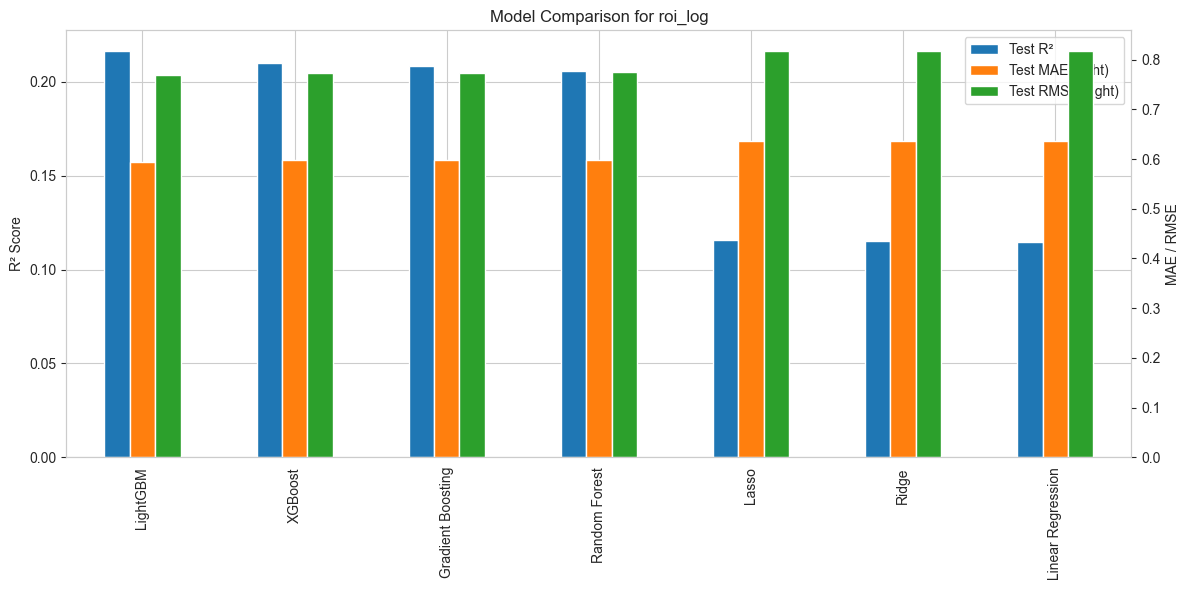

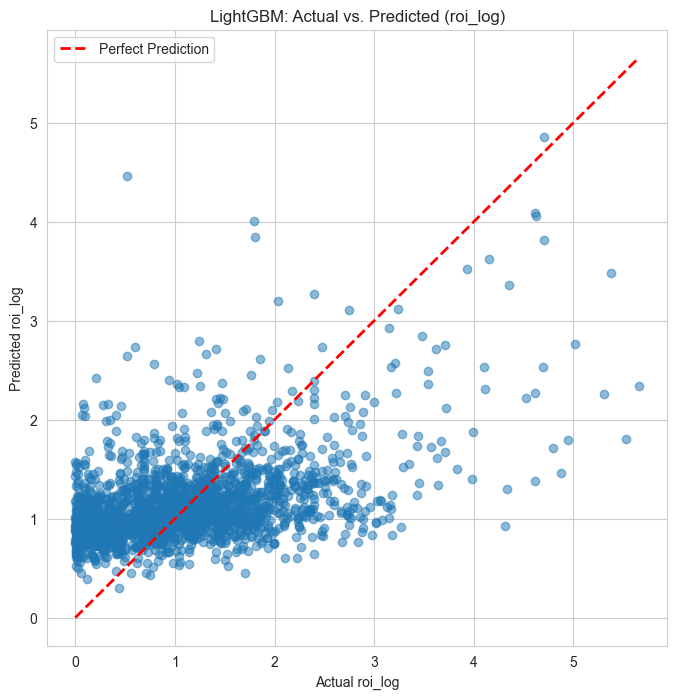

In [42]:
# Iterate Through Each Target Variable
for target_name, y_data in targets.items():
    print(f"\n{'='*20} Processing Target: {target_name} {'='*20}")

    # Prepare Data for Current Target
    y = y_data.copy()

    # Drop rows in X and y where the current target y is NaN
    valid_indices = y.dropna().index
    if len(valid_indices) < len(y):
        print(f"  Target '{target_name}' has {len(y) - len(valid_indices)} NaN(s). Filtering data.")
        X_current = X.loc[valid_indices].copy()
        y_current = y.loc[valid_indices].copy()
    else:
        X_current = X.copy() # Use copies to avoid side effects if X is reused
        y_current = y
        print(f"  Target '{target_name}' has no NaN values.")

    if X_current.empty or len(X_current) < 20: # Check if enough data remains
        print(f"  Skipping target '{target_name}' due to insufficient data after NaN removal ({len(X_current)} samples).")
        continue

    print(f"  Shape after handling NaNs for '{target_name}': X={X_current.shape}, y={y_current.shape}")

    # Train-Test Split for Current Target
    X_train, X_test, y_train, y_test = train_test_split(
        X_current, y_current, test_size=0.2, random_state=random_state
    )
    print(f"  Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
    # Store the test set for later use (SHAP)
    test_sets_per_target[target_name] = {'X_test': X_test, 'y_test': y_test}

    # Training and Tuning Loop for Current Target
    current_target_results = {}
    current_target_estimators = {}
    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    print(f"\n  --- Training and Tuning Models for Target: {target_name} ---")

    for model_name, model in models.items():
        print(f"    Processing model: {model_name}")
        # Create pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), # Use the same preprocessor structure
                                   ('model', model)])

        # Get parameter grid
        current_param_grid = {k: v for k, v in param_grids.get(model_name, {}).items()}

        # Perform Grid Search or Cross-validation
        best_estimator_for_model = None
        best_cv_score_for_model = -np.inf

        try: # Add try-except block for robustness during fitting/tuning
            if current_param_grid:
                search = GridSearchCV(pipeline, current_param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=0)
                search.fit(X_train, y_train)
                best_estimator_for_model = search.best_estimator_
                best_cv_score_for_model = search.best_score_
                print(f"      Best CV R²: {best_cv_score_for_model:.4f}")
                print(f"      Best Params: {search.best_params_}")
            else:
                # Fit directly and use cross_val_score
                pipeline.fit(X_train, y_train)
                best_estimator_for_model = pipeline # Store the fitted pipeline
                cv_scores = cross_val_score(best_estimator_for_model, X_train, y_train, cv=cv, scoring='r2')
                best_cv_score_for_model = np.mean(cv_scores)
                print(f"      CV R² (no tuning): {best_cv_score_for_model:.4f}")

            # Evaluate on the Test set
            y_pred = best_estimator_for_model.predict(X_test)
            test_r2 = r2_score(y_test, y_pred)
            test_mae = mean_absolute_error(y_test, y_pred)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            # Store results for this model and this target
            current_target_results[model_name] = {
                'Best CV R²': best_cv_score_for_model,
                'Test R²': test_r2,
                'Test MAE': test_mae,
                'Test RMSE': test_rmse,
                'Predictions': y_pred # Optional: might consume memory if stored for all
            }
            current_target_estimators[model_name] = best_estimator_for_model

            print(f"      {model_name} -> Test R²: {test_r2:.4f}, Test MAE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}")

        except Exception as e:
            print(f"      ERROR processing model {model_name} for target {target_name}: {e}")
            # Store failure information if needed
            current_target_results[model_name] = {'Error': str(e)}
            current_target_estimators[model_name] = None


    # Find Best Model for the Current Target
    # Filter out models that resulted in an error
    valid_results_for_target = {name: res for name, res in current_target_results.items() if 'Error' not in res}

    if not valid_results_for_target:
        print(f"  No models successfully trained for target: {target_name}")
        best_model_name_for_target = None
        best_model_pipeline_for_target = None
        best_test_r2_for_target = -np.inf
    else:
        best_model_name_for_target = max(valid_results_for_target, key=lambda name: valid_results_for_target[name]['Test R²'])
        best_model_pipeline_for_target = current_target_estimators[best_model_name_for_target]
        best_test_r2_for_target = valid_results_for_target[best_model_name_for_target]['Test R²']

        print(f"\n  --- Best Model for {target_name} based on Test R² ---")
        print(f"  Model: {best_model_name_for_target}")
        print(f"  Test R²: {best_test_r2_for_target:.4f}")

        # Store the best model info for this target
        best_model_per_target[target_name] = {
            'model_name': best_model_name_for_target,
            'pipeline': best_model_pipeline_for_target,
            'test_r2': best_test_r2_for_target,
            'test_mae': valid_results_for_target[best_model_name_for_target]['Test MAE'],
            'test_rmse': valid_results_for_target[best_model_name_for_target]['Test RMSE']
        }

    # Store all results and estimators for this target
    all_results[target_name] = current_target_results
    all_best_estimators[target_name] = current_target_estimators

    # Visualize Current Target Results
    # Visualize Model Comparison for the Current Target
    print(f"\n  --- Model Comparison for Target: {target_name} ---")
    if valid_results_for_target:
        # Create a DataFrame of results, sorted by 'Test R²'
        results_df = pd.DataFrame(valid_results_for_target).T.sort_values(by='Test R²', ascending=False)
        print(results_df[['Best CV R²', 'Test R²', 'Test MAE', 'Test RMSE']])
    
        # Create the plot
        ax = results_df[['Test R²', 'Test MAE', 'Test RMSE']].plot(kind='bar', figsize=(12, 6), secondary_y=['Test MAE', 'Test RMSE'])
    
        # Set labels for both y-axes
        ax.set_ylabel('R² Score')  # Primary y-axis for R² Score
        ax.right_ax.set_ylabel('MAE / RMSE')  # Secondary y-axis for MAE / RMSE
    
        # Title and formatting
        plt.title(f'Model Comparison for {target_name}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
        # Visualize predictions for the best model for this target
        if best_model_name_for_target:
            y_pred_best = valid_results_for_target[best_model_name_for_target]['Predictions']
            y_test_current = test_sets_per_target[target_name]['y_test']  # Retrieve y_test
    
            plt.figure(figsize=(8, 8))
            plt.scatter(y_test_current, y_pred_best, alpha=0.5)
            min_val = min(y_test_current.min(), y_pred_best.min())
            max_val = max(y_test_current.max(), y_pred_best.max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
            plt.xlabel(f"Actual {target_name}")
            plt.ylabel(f"Predicted {target_name}")
            plt.title(f"{best_model_name_for_target}: Actual vs. Predicted ({target_name})")
            plt.legend()
            plt.grid(True)
            plt.show()
    else:
        print("  No valid results to visualize for this target.")

In [43]:
print(f"\n{'='*20} Overall Summary of Best Models {'='*20}")
summary_list = []
for target, info in best_model_per_target.items():
    summary_list.append({
        'Target': target,
        'Best Model': info['model_name'],
        'Test R²': info['test_r2'],
        'Test MAE': info['test_mae'],
        'Test RMSE': info['test_rmse']
    })
summary_df = pd.DataFrame(summary_list).sort_values('Test R²', ascending=False)


==================== Overall Summary of Best Models ====================


In [44]:
summary_df

,Target,Best Model,Test R²,Test MAE,Test RMSE
2,vote_count_log,LightGBM,0.656830,0.977881,1.286392
1,popularity_log,XGBoost,0.643214,0.399803,0.544250
0,revenue_log,XGBoost,0.611223,1.187754,1.635541
3,vote_average,LightGBM,0.280060,0.661948,0.915061
4,roi_log,LightGBM,0.216527,0.593602,0.769480


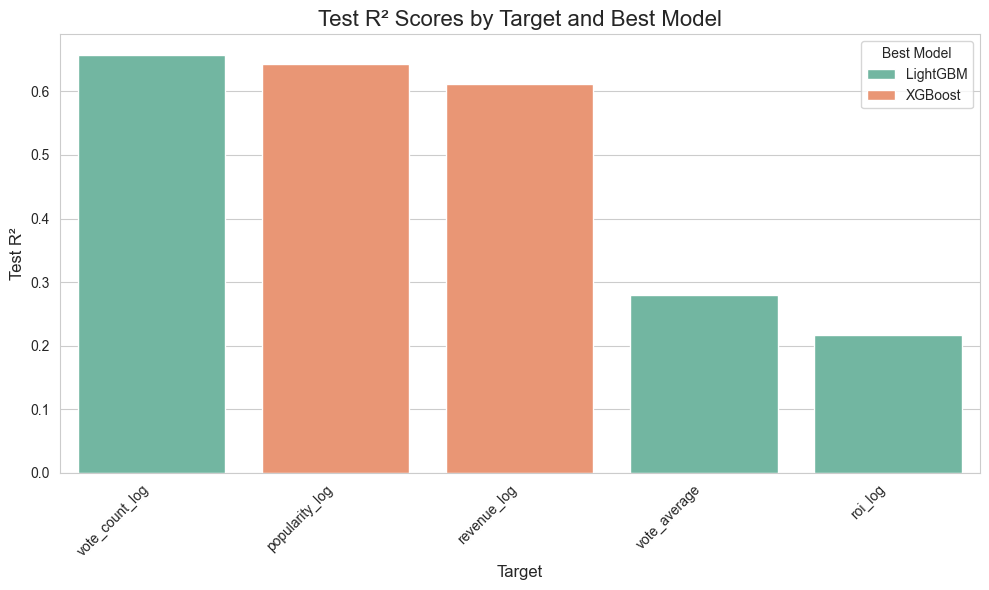

In [45]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x="Target",
    y="Test R²",
    hue="Best Model",
    data=summary_df,
    dodge=False, # to color by model but keep bars together
    palette="Set2" # you can change the palette if you want
)

# Add titles and labels
plt.title("Test R² Scores by Target and Best Model", fontsize=16)
plt.xlabel("Target", fontsize=12)
plt.ylabel("Test R²", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Best Model")

# Show plot
plt.tight_layout()
plt.show()

In [48]:
best_pipeline = best_model_per_target[target_name]['pipeline']
final_model = best_pipeline.named_steps['model']
print(final_model.get_params())


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbosity': -1}



==================== SHAP Analysis for Best Models per Target ====================

--- SHAP Analysis for Target: revenue_log (Best Model: XGBoost) ---
  Processed test data shape for SHAP: (1944, 44)
  Calculating SHAP values...
  SHAP values calculated.
  --- SHAP Summary Plot (Global Importance) ---


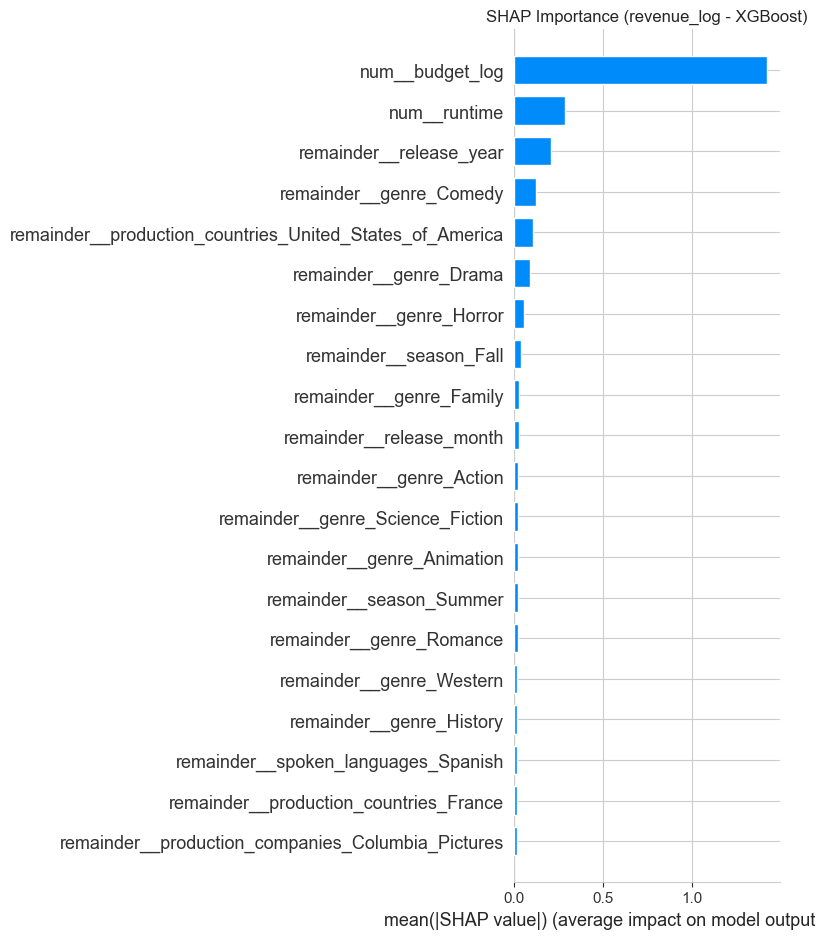

  --- SHAP Summary Plot (Value Distribution) ---


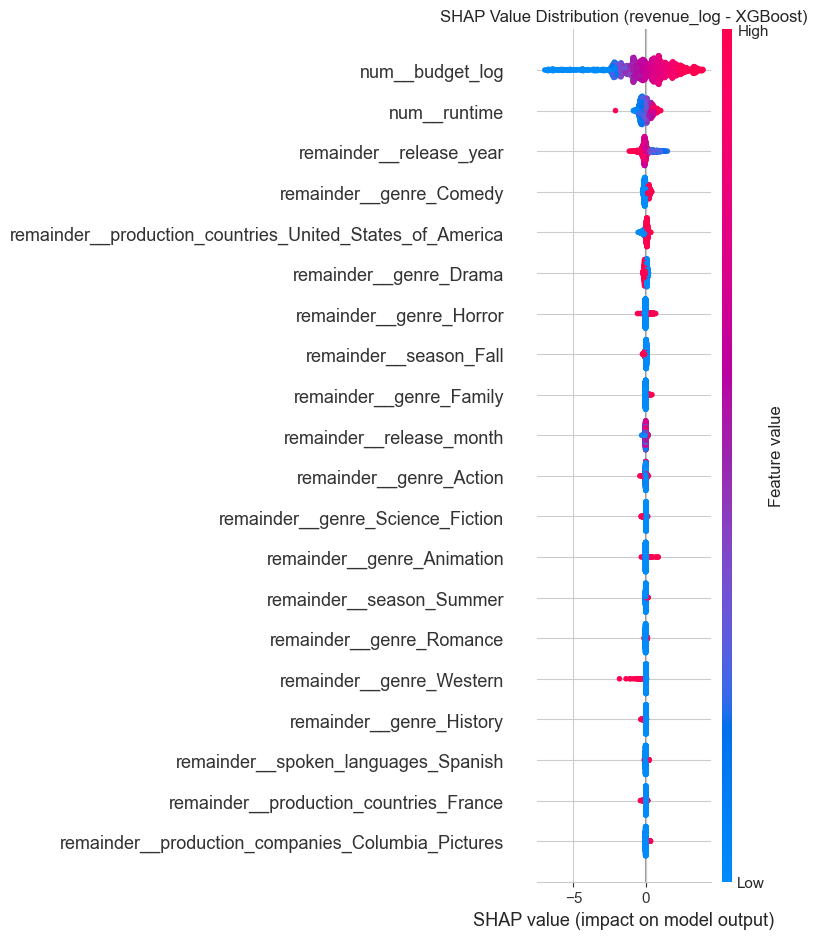


--- SHAP Analysis for Target: popularity_log (Best Model: XGBoost) ---
  Processed test data shape for SHAP: (1944, 44)
  Calculating SHAP values...
  SHAP values calculated.
  --- SHAP Summary Plot (Global Importance) ---


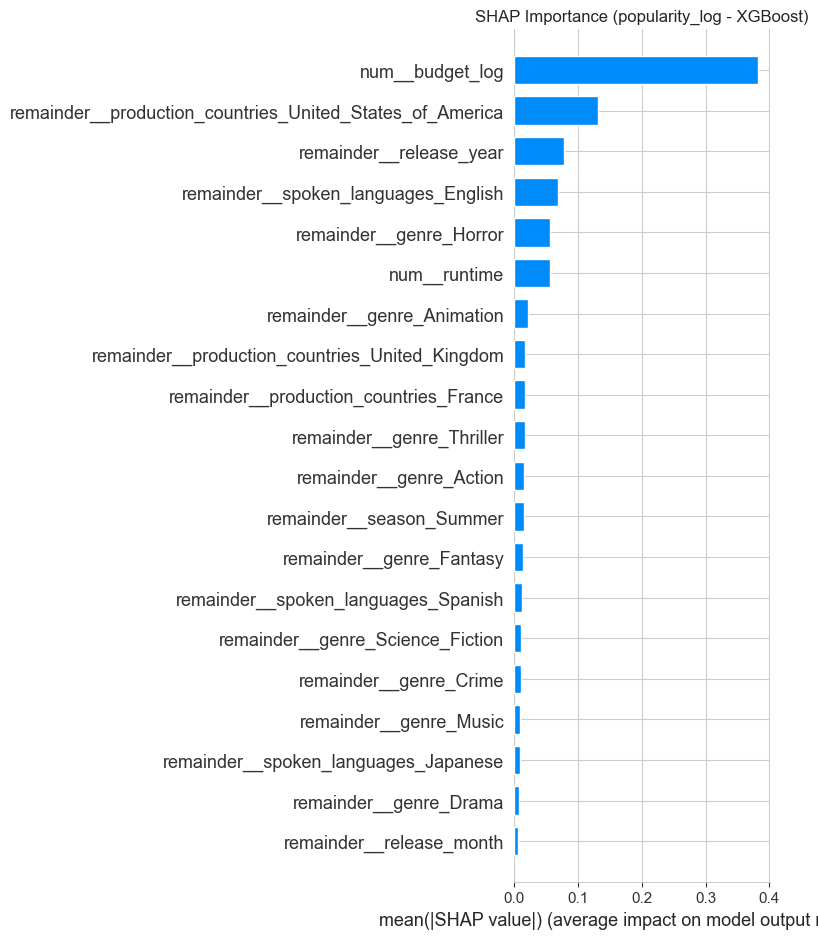

  --- SHAP Summary Plot (Value Distribution) ---


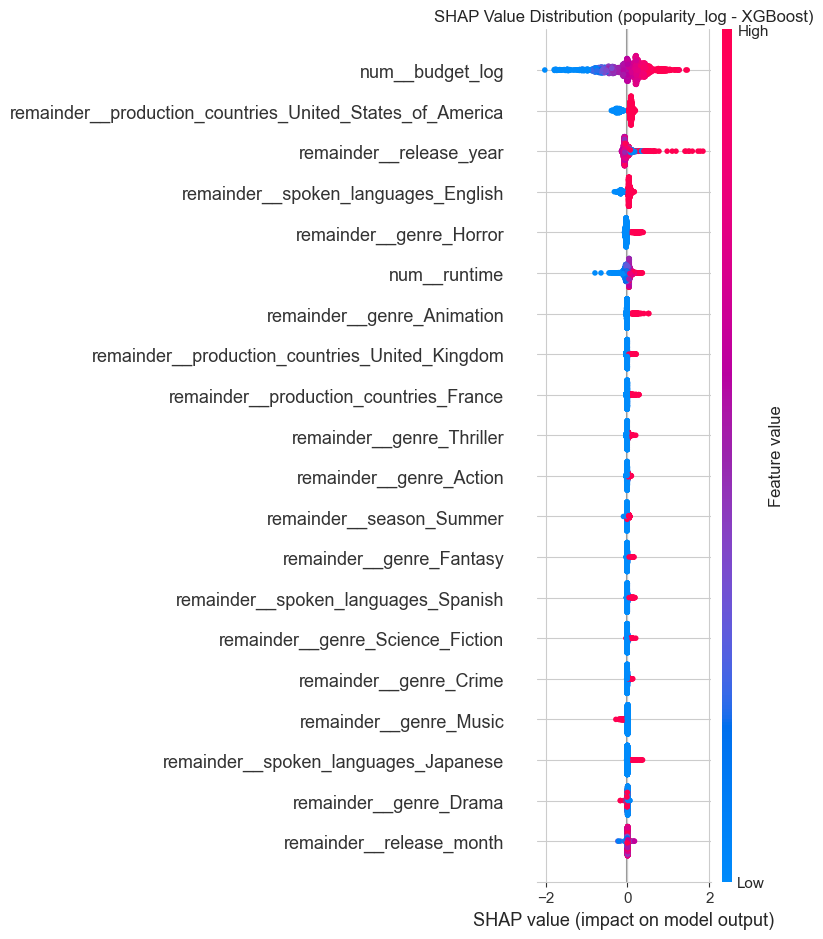


--- SHAP Analysis for Target: vote_count_log (Best Model: LightGBM) ---
  Processed test data shape for SHAP: (1944, 44)
  Calculating SHAP values...
  SHAP values calculated.
  --- SHAP Summary Plot (Global Importance) ---


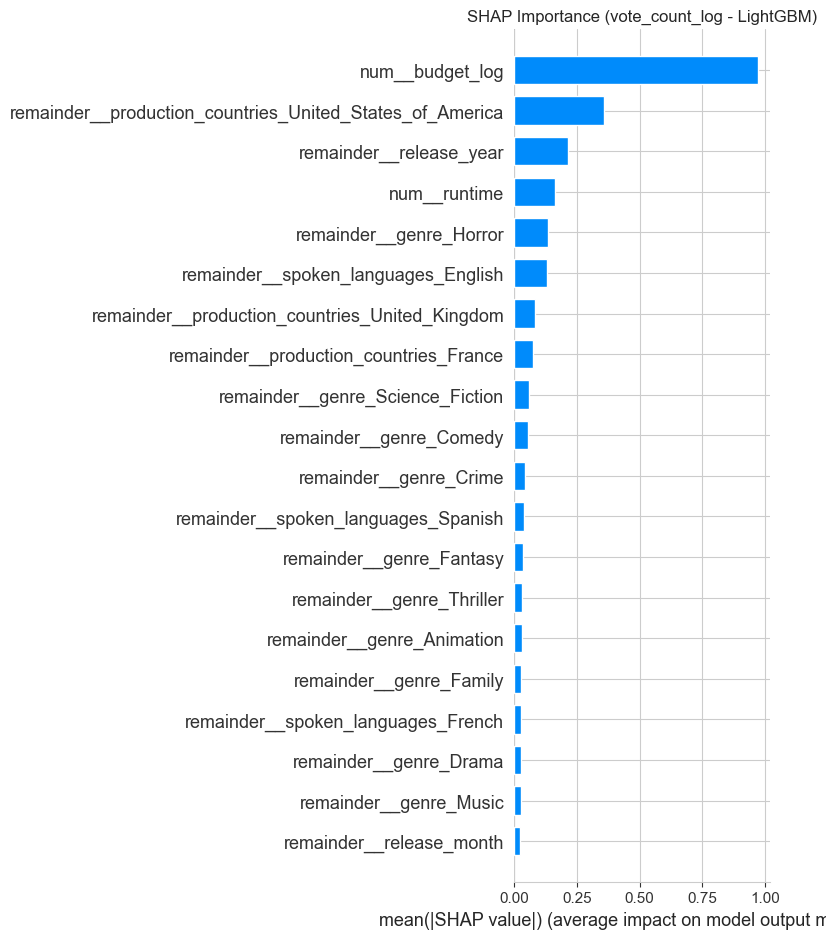

  --- SHAP Summary Plot (Value Distribution) ---


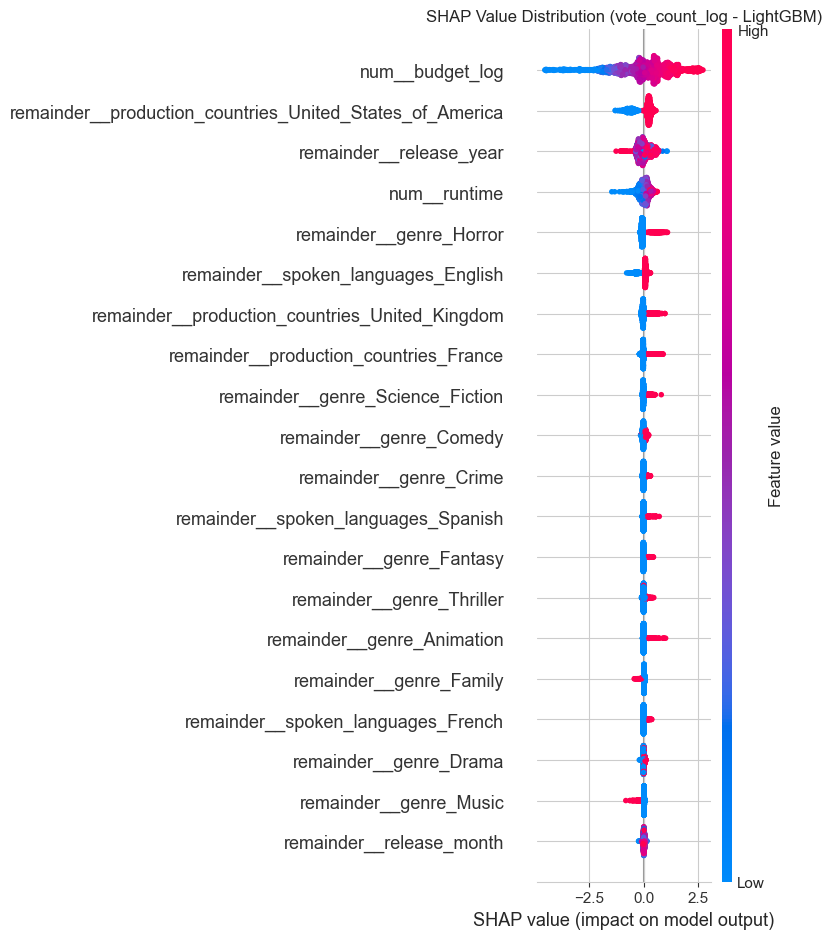


--- SHAP Analysis for Target: vote_average (Best Model: LightGBM) ---
  Processed test data shape for SHAP: (1944, 44)
  Calculating SHAP values...
  SHAP values calculated.
  --- SHAP Summary Plot (Global Importance) ---


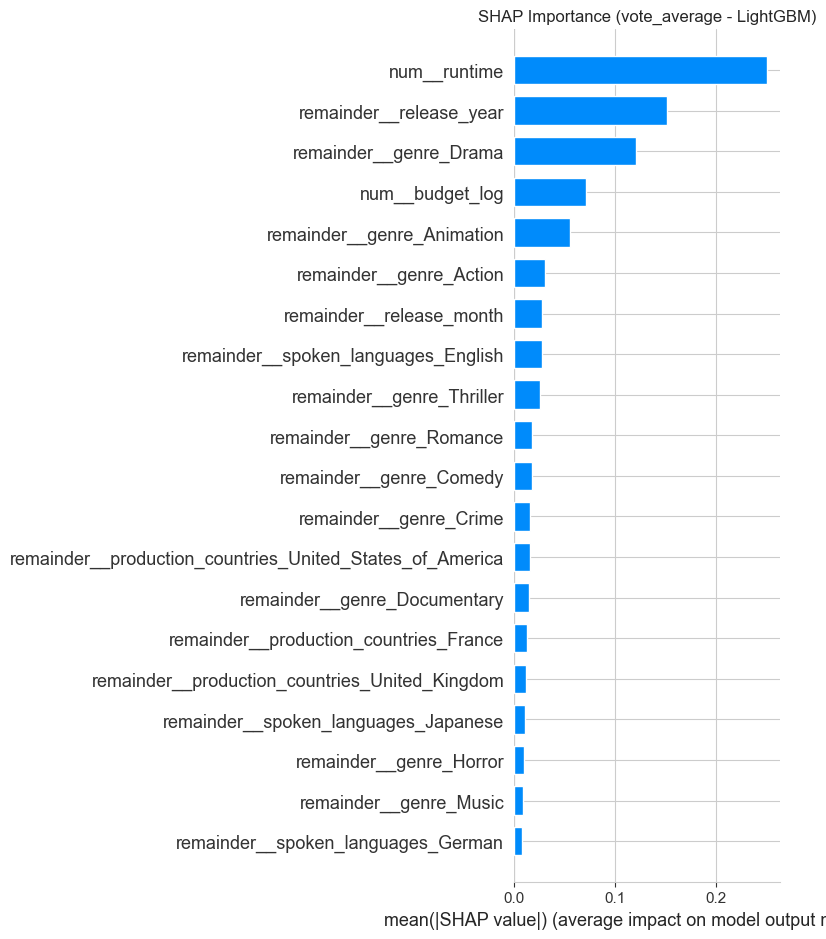

  --- SHAP Summary Plot (Value Distribution) ---


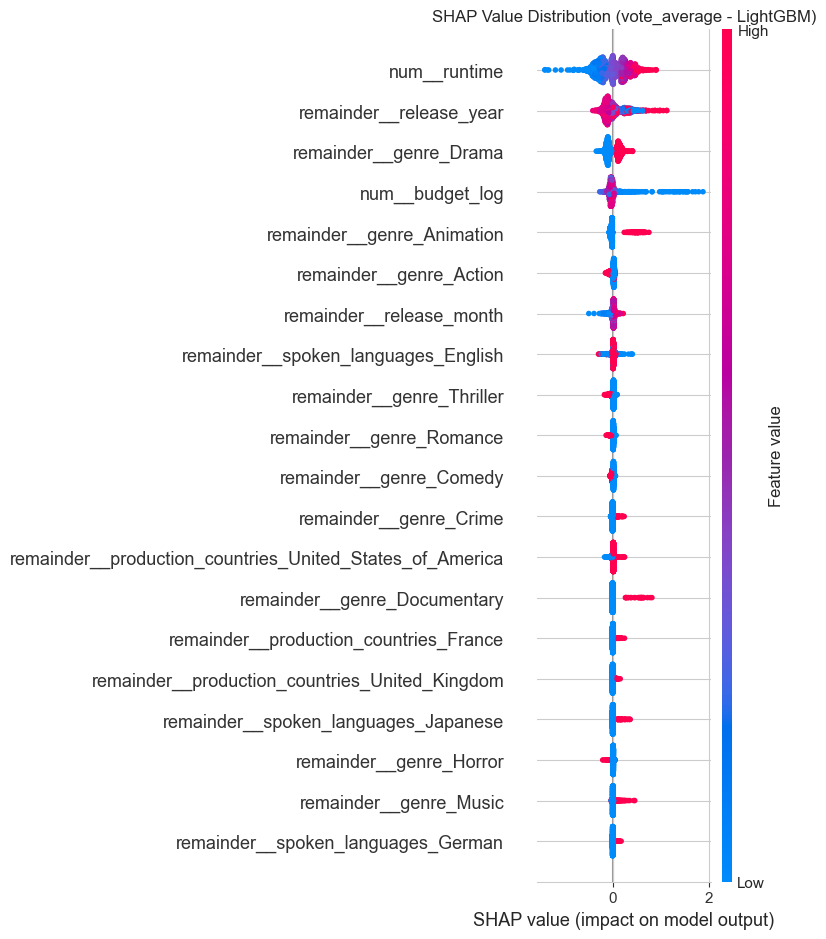


--- SHAP Analysis for Target: roi_log (Best Model: LightGBM) ---
  Processed test data shape for SHAP: (1944, 44)
  Calculating SHAP values...
  SHAP values calculated.
  --- SHAP Summary Plot (Global Importance) ---


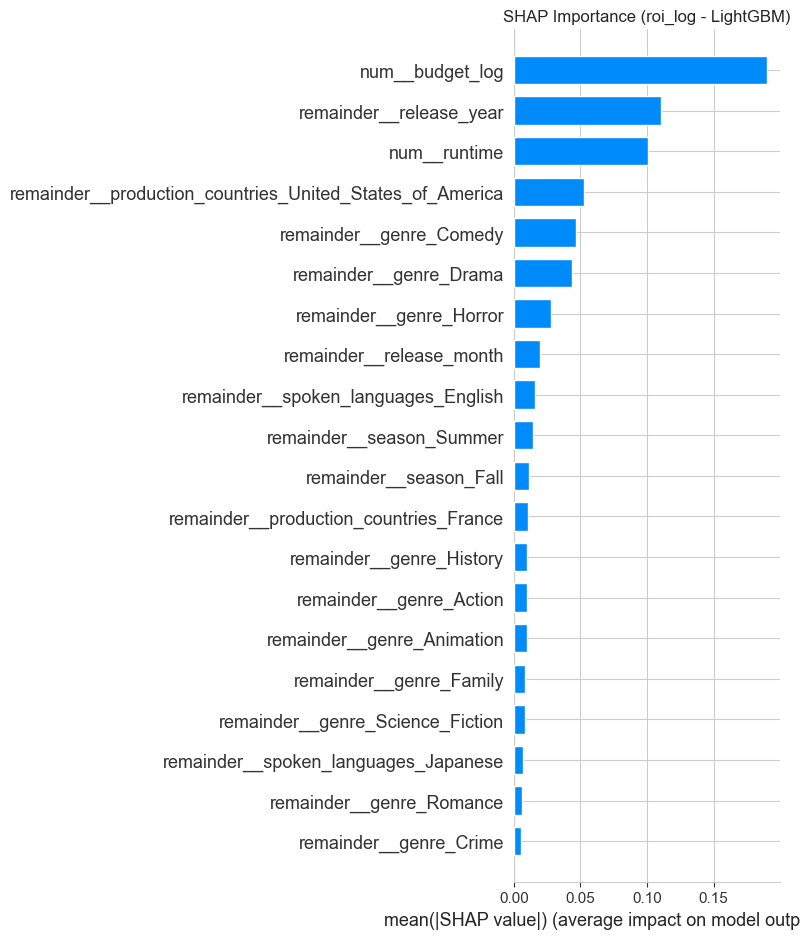

  --- SHAP Summary Plot (Value Distribution) ---


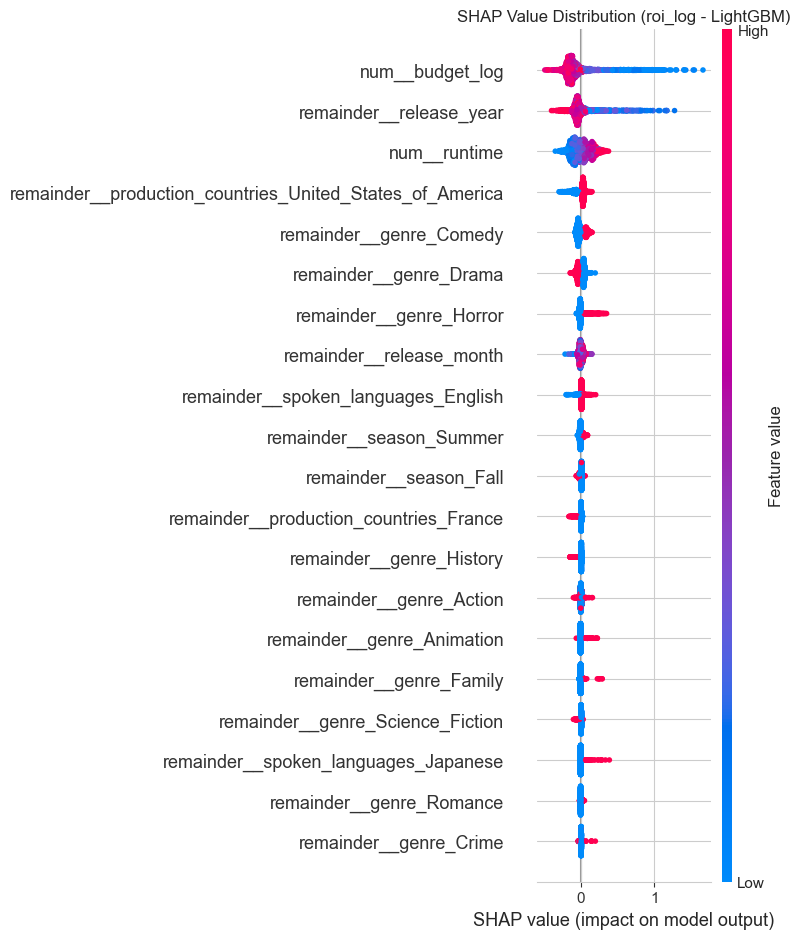

In [47]:

# ==============================================================================
# --- 7. Feature Importance Analysis & Interpretation (SHAP) - Adapted ---
# ==============================================================================
# Now loop through the best model found for each target


print(f"\n{'='*20} SHAP Analysis for Best Models per Target {'='*20}")

for target_name, best_info in best_model_per_target.items():
    print(f"\n--- SHAP Analysis for Target: {target_name} (Best Model: {best_info['model_name']}) ---")

    best_model_pipeline = best_info['pipeline']
    if best_model_pipeline is None:
        print(f"  Skipping SHAP for {target_name} as the best model object is missing.")
        continue

    # Retrieve the correct X_test for this target
    if target_name not in test_sets_per_target:
         print(f"  Skipping SHAP for {target_name} as test set data is missing.")
         continue
    X_test_current = test_sets_per_target[target_name]['X_test']

    # Extract the trained model and preprocessor from the best pipeline
    try:
        best_model = best_model_pipeline.named_steps['model']
        preprocessor_fitted = best_model_pipeline.named_steps['preprocessor']
    except (AttributeError, KeyError) as e:
        print(f"  Could not extract model/preprocessor from pipeline for {target_name}: {e}. Skipping SHAP.")
        continue


    # Transform the test data using the fitted preprocessor
    try:
        feature_names_out = preprocessor_fitted.get_feature_names_out()
        # Ensure sparse matrix is handled if necessary, use correct columns
        X_test_processed = pd.DataFrame(preprocessor_fitted.transform(X_test_current), columns=feature_names_out, index=X_test_current.index)
    except AttributeError:
         print("  Warning: Could not automatically get feature names from preprocessor. SHAP plots might have generic names.")
         X_test_processed = pd.DataFrame(preprocessor_fitted.transform(X_test_current), index=X_test_current.index)
    except Exception as e:
        print(f"  Error transforming X_test for SHAP on {target_name}: {e}. Skipping.")
        continue


    print(f"  Processed test data shape for SHAP: {X_test_processed.shape}")

    # Initialize SHAP explainer
    model_type_str = str(type(best_model)).lower()
    if 'gradientboosting' in model_type_str or 'forest' in model_type_str or 'xgboost' in model_type_str or 'lightgbm' in model_type_str:
         explainer = shap.TreeExplainer(best_model)
    else:
         # For KernelExplainer, need background data from the *correct* X_train for this target
         # This requires storing X_train or refitting the preprocessor - let's simplify for now
         # We will try TreeExplainer anyway, might work for some linear models too, or warn user
         print(f"  Attempting SHAP TreeExplainer for non-tree model ({best_info['model_name']}). May be approximate or fail.")
         explainer = shap.TreeExplainer(best_model)
         # Alternative (more correct but complex): Store X_train or refit preprocessor
         # X_train_current = ... retrieve or recreate ...
         # X_train_processed_sample = pd.DataFrame(preprocessor_fitted.transform(X_train_current.sample(min(100, len(X_train_current)), random_state=random_state)), columns=X_test_processed.columns)
         # explainer = shap.KernelExplainer(best_model.predict, X_train_processed_sample)

    # Calculate SHAP values
    print("  Calculating SHAP values...")
    shap_values = explainer.shap_values(X_test_processed)
    print("  SHAP values calculated.")

    if isinstance(shap_values, list) and len(shap_values) > 0: # Handle list output if needed
        shap_values = shap_values[0]

    # --- SHAP Plots ---
    print("  --- SHAP Summary Plot (Global Importance) ---")
    plt.figure()
    shap.summary_plot(shap_values, X_test_processed, plot_type="bar", show=False)
    plt.title(f'SHAP Importance ({target_name} - {best_info["model_name"]})')
    plt.tight_layout()
    plt.show()

    print("  --- SHAP Summary Plot (Value Distribution) ---")
    plt.figure()
    shap.summary_plot(shap_values, X_test_processed, show=False)
    plt.title(f'SHAP Value Distribution ({target_name} - {best_info["model_name"]})')
    plt.tight_layout()
    plt.show()

    # --- Dependence Plots ---
    # mean_abs_shap = np.abs(shap_values).mean(axis=0)
    # # Ensure mean_abs_shap length matches number of columns
    # if len(mean_abs_shap) != len(X_test_processed.columns):
    #     print(f"  Warning: SHAP values dimension mismatch ({len(mean_abs_shap)}) vs columns ({len(X_test_processed.columns)}). Skipping dependence plots.")
    # else:
    #     importance_df = pd.DataFrame({
    #         'feature': X_test_processed.columns,
    #         'mean_abs_shap': mean_abs_shap
    #     }).sort_values('mean_abs_shap', ascending=False)
    # 
    #     top_n_features = 5
    #     print(f"  --- SHAP Dependence Plots for Top {top_n_features} Features ---")
    #     for feature in importance_df['feature'].head(top_n_features):
    #         print(f"    Generating dependence plot for: {feature}")
    #         plt.figure()
    #         try:
    #             shap.dependence_plot(feature, shap_values, X_test_processed, interaction_index='auto', show=False)
    #             plt.title(f'SHAP Dependence: {feature} ({target_name})')
    #             plt.tight_layout()
    #             plt.show()
    #         except Exception as e:
    #             print(f"      Could not generate dependence plot for {feature}: {e}")
    #             plt.close()

In [50]:

# ==============================================================================
# --- 8. Analysis and Insights based on Goals ---
# ==============================================================================
# This section would now ideally synthesize findings across the different targets,
# referring to the best model and SHAP plots generated for each specific target.
# Example: "For predicting revenue, [Model X] performed best, with Budget being the top driver.
# For popularity, [Model Y] was best, highlighting the importance of [Feature Z]..."
print("\n--- Analysis and Insights ---")
print("Refer to the plots generated above and the summary table for insights.")
print("Analyze SHAP plots for the *best model* identified for each *specific target* (revenue, popularity, roi, etc.)")
# (The detailed markdown interpretation section should be updated based on these multi-target results)


--- Analysis and Insights ---
Refer to the plots generated above and the summary table for insights.
Analyze SHAP plots for the *best model* identified for each *specific target* (revenue, popularity, roi, etc.)


In [28]:
df_processed

,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,original_language,original_title,overview,popularity,keywords,release_year,release_quarter,release_season,release_month,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,production_companies_Warner_Bros._Pictures,production_companies_BBC,production_companies_Evil_Angel,production_companies_Columbia_Pictures,production_companies_Metro-Goldwyn-Mayer,production_countries_United_States_of_America,production_countries_France,production_countries_Japan,production_countries_Germany,production_countries_United_Kingdom,spoken_languages_English,spoken_languages_French,spoken_languages_Spanish,spoken_languages_Japanese,spoken_languages_German,roi,season_Fall,season_Spring,season_Summer,season_Winter,budget_log,revenue_log,vote_count_log,popularity_log,roi_log
0,Inception,8.364,34495,Released,2010-07-15,825532764,148,0,160000000,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,"rescue, mission, dream, airplane, paris, franc...",2010,3,Summer,7,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1,1,1,0,1,0,4.159580,0.0,0.0,1.0,0.0,18.890684,20.531540,10.448599,4.442086,1.817984
1,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,0,165000000,en,Interstellar,The adventures of a group of explorers who mak...,140.241,"rescue, future, spacecraft, race against time,...",2014,4,Fall,11,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,3.252904,1.0,0.0,0.0,0.0,18.921456,20.369058,10.391208,4.950468,1.658752
2,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,0,185000000,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,"joker, sadism, chaos, secret identity, crime f...",2008,3,Summer,7,1,0,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,4.430046,0.0,0.0,1.0,0.0,19.035866,20.727814,10.329409,4.880094,1.860958
3,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,0,237000000,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,"future, society, culture clash, space travel, ...",2009,4,Winter,12,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,11.336312,0.0,0.0,0.0,1.0,19.283571,21.796118,10.302800,4.393609,2.590479
4,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,0,220000000,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,"new york city, superhero, shield, based on com...",2012,2,Spring,4,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,5.903707,0.0,1.0,0.0,0.0,19.209138,21.141197,10.280793,4.595948,2.067313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715,Billy Yeager The Ineffable Enigma,10.000,1,Released,2016-07-30,2350000,102,0,165000,en,Billy Yeager The Ineffable Enigma,"Billy Yeager is a musician, singer-songwriter,...",0.600,musician,2016,3,Summer,7,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,13.242344,0.0,0.0,1.0,0.0,12.013707,14.669926,0.693147,0.470004,2.724067
9716,Oye Kuch Kar Guzar,10.000,1,Released,2016-12-03,5000,98,0,5000,ur,اوئے کچھ کر گزار,Oye Kuch Kar Guzar is a 2016 Pakistani online ...,0.600,"road trip, road movie, train trip",2016,4,Winter,12,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0.0,0.0,1.0,8.517393,8.517393,0.693147,0.470004,0.693071
9717,Auto Shop of Horrors,10.000,1,Released,2016-10-26,4300,86,0,1200,en,Auto Shop of Horrors,"A mentally disturbed car mechanic, with a deep...",0.643,"dark comedy, parody, horror spoof",2016,4,Fall,10,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2.581182,1.0,0.0,0.0,0.0,7.090910,8.366603,0.693147,0.496524,1.521924
9718,Full Grown Men,6.000,1,Released,2006-04-27,13716,78,0,2000000,en,Full Grown Men,A man stuck in the reveries of his youth track...,1.474,"mermaid, road trip, amusement park, childhood ...",2006,2,Spring,4,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,-0.

In [29]:
# Add this to the end of your data preparation section in prediction.py
# or run it separately after df_processed is created.
df_processed.to_parquet("output/df_processed_for_streamlit.parquet", index=False)
print("Saved df_processed to output/df_processed_for_streamlit.parquet")

Saved df_processed to output/df_processed_for_streamlit.parquet


In [63]:
def clean_and_enhance_movie_data(df, min_runtime=15, max_runtime=400, min_budget_revenue=1000, max_scale_mismatch=10000):    
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Drop rows where release_date is null
    df = df.dropna(subset=['release_date']).reset_index(drop=True)
    
    # Ensure runtime is reasonable
    df = df[(df['runtime'] >= min_runtime) & (df['runtime'] < max_runtime)].reset_index(drop=True)
    
    # Address potential data entry errors (budget/revenue scale)
    filtered_check = df[["title", "revenue", "budget"]].copy()
    
    # Only compute scale mismatch where revenue is not zero
    filtered_check['scale_mismatch'] = 0
    nonzero_revenue = df['revenue'] != 0
    filtered_check.loc[nonzero_revenue, 'scale_mismatch'] = (df.loc[nonzero_revenue, 'revenue'] / df.loc[nonzero_revenue, 'budget']).fillna(0).replace(np.inf, 0)
    
    # Handle cases where budget > revenue
    filtered_check['scale_mismatch'] = filtered_check['scale_mismatch'].apply(
        lambda x: x if x >= 1 else (1 / x if x > 0 else 0))
    
    # Define which rows to drop
    to_drop_indices = df[
        ((df['revenue'] < min_budget_revenue)|
        (df['budget'] < min_budget_revenue) |
        (filtered_check['scale_mismatch'] >= max_scale_mismatch))
        & (df['revenue'] != 0)# <--- Important: only consider if revenue != 0
    ].index
    
    if not to_drop_indices.empty:
        print(f"Dropping {len(to_drop_indices)} entries due to potential budget/revenue data errors.")
        print("Examples being dropped:")
        print(df.loc[to_drop_indices, ['title', 'budget', 'revenue']].head())
        df = df.drop(index=to_drop_indices).reset_index(drop=True)


    # Calculate Return on Investment (ROI)
    # Only if both revenue and budget are not zero
    epsilon = 1e-6
    df['roi'] = np.where(
        (df['revenue'] != 0) & (df['budget'] != 0),
        (df['revenue'] - df['budget']) / (df['budget'] + epsilon),
        0  # or np.nan if you prefer
    )
    


    
    cols_to_log = ['budget', 'revenue', 'vote_count', 'popularity', 'roi']
    
    # Log Transformation & Scaling
    # df_processed = df.copy()
    numerical_cols_log = []
    
    for col in cols_to_log:
        if col == 'roi':
            # Shift ROI to be positive before log transforming
            min_roi = df[col].min()
            if min_roi <= 0:
                shifted_roi = df[col] - min_roi + 1e-6
                df[f'{col}_log'] = np.where(
                    df[col] != 0,
                    np.log1p(shifted_roi),
                    0  # or np.nan if you prefer
                )
                print(f"Applied log1p to shifted ROI (min shifted to > 0)")
            else:
                df[f'{col}_log'] = np.where(
                    df[col] != 0,
                    np.log1p(df[col]),
                    0
                )
        else:
            df[f'{col}_log'] = np.where(
                df[col] != 0,
                np.log1p(df[col]),
                0
            )
        
        numerical_cols_log.append(f'{col}_log')
        print(f"Log-transformed '{col}' -> '{col}_log'")
    
    # # Genre count
    # genre_cols = [col for col in df.columns if col.startswith('genre_')]
    # df['genre_count'] = df[genre_cols].sum(axis=1)
    
    # One-hot encode release seasons
    if 'release_season' in df.columns:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        season_encoded = encoder.fit_transform(df[['release_season']])
        
        # Create column names for the encoded features
        season_cols = [f'season_{season}' for season in encoder.categories_[0]]
        
        # Add encoded columns to dataframe
        season_df = pd.DataFrame(season_encoded, columns=season_cols, index=df.index)
        df = pd.concat([df, season_df], axis=1)
    
    return df

In [71]:
in_prod_df = pd.read_csv("output/in_prod_nonzero.csv", index_col=None)
in_prod_df = clean_and_enhance_movie_data(in_prod_df)
post_prod_df = pd.read_csv("output/post_prod_nonzero.csv", index_col=None)
post_prod_df = clean_and_enhance_movie_data(post_prod_df)
complete_df = pd.read_parquet("output/many_movies.parquet")
complete_df = clean_and_enhance_movie_data(complete_df)

Dropping 25 entries due to potential budget/revenue data errors.
Examples being dropped:
                                  title  budget  revenue
17  Mother's Ruin: Unmasking the WMSCOG     300      300
28                           Rupert’s 6     300       20
50                BAGMAN-THE BLUE BEAST     500    10896
55                         The Ensemble       1        2
96                  THREE COOL PEOPLE 5      19        1
Log-transformed 'budget' -> 'budget_log'
Log-transformed 'revenue' -> 'revenue_log'
Log-transformed 'vote_count' -> 'vote_count_log'
Log-transformed 'popularity' -> 'popularity_log'
Applied log1p to shifted ROI (min shifted to > 0)
Log-transformed 'roi' -> 'roi_log'
Dropping 5 entries due to potential budget/revenue data errors.
Examples being dropped:
                         title  budget  revenue
84             INSIDE OUT 2024     744        7
85    Alice in Wonderland 2024     700       10
88               SpyGlass 2024      60       10
90   Christmas Switch 

In [72]:
def prepare_dataframe_for_prediction(df, feature_columns):
    """
    Extract features from the dataframe using the same columns as in training.
    Returns a feature matrix and the valid indices used.
    """
    # Print info about the dataframe
    print(f"Dataframe shape: {df.shape}")
    
    # Check if all required feature columns exist
    missing_cols = [col for col in feature_columns if col not in df.columns]
    if missing_cols:
        print(f"Warning: Missing feature columns in data: {missing_cols}")
        print("Will only use available columns")
        feature_columns = [col for col in feature_columns if col in df.columns]
    
    # Create initial feature matrix
    X_new = df[feature_columns].copy()
    
    # Check for NaN values in features
    nan_rows = X_new.isna().any(axis=1)
    rows_with_nans = nan_rows.sum()
    
    if rows_with_nans > 0:
        print(f"Warning: {rows_with_nans} rows contain NaN values in features")
        print("Filling NaN values with appropriate defaults")
        
        # Fill numeric columns with 0, categorical with most common value
        for col in X_new.columns:
            if X_new[col].dtype.kind in 'fc':  # float or complex
                X_new[col].fillna(0, inplace=True)
            else:
                X_new[col].fillna(0, inplace=True)  # For categorical, fill with 0
    
    return X_new, X_new.index

In [73]:
# Use the same feature columns as in training (X_cols)
# Process both new dataframes
print(f"Extracting features using available columns from {len(X_cols)} possible feature columns")

X_in_prod, in_prod_indices = prepare_dataframe_for_prediction(in_prod_df, X_cols)
X_post_prod, post_prod_indices = prepare_dataframe_for_prediction(post_prod_df, X_cols)
X_complete, complete_indices = prepare_dataframe_for_prediction(complete_df, X_cols)

print(f"Feature matrices created successfully:")
print(f"  in_prod features shape: {X_in_prod.shape}")
print(f"  post_prod features shape: {X_post_prod.shape}")
print(f"  X_complete features shape: {X_complete.shape}")


Extracting features using available columns from 44 possible feature columns
Dataframe shape: (359, 62)
Dataframe shape: (166, 62)
Dataframe shape: (579270, 62)
Feature matrices created successfully:
  in_prod features shape: (359, 44)
  post_prod features shape: (166, 44)
  X_complete features shape: (579270, 44)


In [74]:
# Make predictions for each target using the best models
predictions = {}

# Define the target variables (same as in training)
target_variables = [
    'revenue_log', 
    'popularity_log', 
    'vote_count_log', 
    'vote_average', 
    'roi_log'
]

print("\nMaking predictions for each target variable:")
for target_name in target_variables:
    if target_name in best_model_per_target:
        print(f"Processing target: {target_name}")
        
        # Get the best pipeline for this target
        model_info = best_model_per_target[target_name]
        best_pipeline = model_info['pipeline']
        best_model_name = model_info['model_name']
        
        # Make predictions for both new dataframes
        try:
            # Initialize dictionaries for this target if not already done
            if target_name not in predictions:
                predictions[target_name] = {'in_prod': {}, 'post_prod': {}, 'complete': {}}
            
            # Make predictions with indices
            in_prod_preds = best_pipeline.predict(X_in_prod)
            post_prod_preds = best_pipeline.predict(X_post_prod)
            complete_preds = best_pipeline.predict(X_complete)
            
            # Store predictions with their indices
            predictions[target_name]['in_prod'] = dict(zip(in_prod_indices, in_prod_preds))
            predictions[target_name]['post_prod'] = dict(zip(post_prod_indices, post_prod_preds))
            predictions[target_name]['complete'] = dict(zip(complete_indices, complete_preds))
            
            print(f"  Successfully predicted {target_name} using {best_model_name}")
            
            # If the target was log-transformed, also store the back-transformed values
            if target_name.endswith('_log'):
                original_name = target_name.replace('_log', '')
                
                if original_name not in predictions:
                    predictions[original_name] = {'in_prod': {}, 'post_prod': {}, 'complete': {}}
                
                # Back-transform the predictions (expm1 for log1p)
                predictions[original_name]['in_prod'] = {idx: np.expm1(val) for idx, val in predictions[target_name]['in_prod'].items()}
                predictions[original_name]['post_prod'] = {idx: np.expm1(val) for idx, val in predictions[target_name]['post_prod'].items()}
                predictions[original_name]['complete'] = {idx: np.expm1(val) for idx, val in predictions[target_name]['complete'].items()}
                
                print(f"  Also converted {target_name} back to {original_name}")
                
        except Exception as e:
            print(f"  Error predicting {target_name}: {e}")
    else:
        print(f"No best model found for {target_name}, skipping predictions")


Making predictions for each target variable:
Processing target: revenue_log
  Successfully predicted revenue_log using XGBoost
  Also converted revenue_log back to revenue
Processing target: popularity_log
  Successfully predicted popularity_log using XGBoost
  Also converted popularity_log back to popularity
Processing target: vote_count_log
  Successfully predicted vote_count_log using LightGBM
  Also converted vote_count_log back to vote_count
Processing target: vote_average
  Successfully predicted vote_average using LightGBM
Processing target: roi_log
  Successfully predicted roi_log using LightGBM
  Also converted roi_log back to roi


In [75]:
# Add predictions to the original dataframes and calculate errors where applicable
for target_name in predictions:
    # Define the original column name (without _log suffix if it exists)
    original_name = target_name.replace('_log', '') if target_name.endswith('_log') else target_name
    pred_colname = f'predicted_{original_name}'
    
    print(f"\nAdding predictions for {original_name} to dataframes...")
    
    # Add predictions to in_prod_df (dataframe by dataframe approach)
    if target_name in predictions and 'in_prod' in predictions[target_name]:
        # Get the prediction dictionary with index->value mapping
        pred_dict = predictions[target_name]['in_prod']
        if not target_name.endswith('_log') and original_name in predictions:
            # Use the non-log values if available
            pred_dict = predictions[original_name]['in_prod']
        
        # Create a Series with the right index
        pred_series = pd.Series(pred_dict)
        
        # Assign only to rows that exist in the original dataframe
        in_prod_df[pred_colname] = pred_series
        print(f"  Added {pred_colname} to in_prod_df")
    
    # Add predictions to post_prod_df
    if target_name in predictions and 'post_prod' in predictions[target_name]:
        # Get the prediction dictionary with index->value mapping
        pred_dict = predictions[target_name]['post_prod']
        if not target_name.endswith('_log') and original_name in predictions:
            # Use the non-log values if available
            pred_dict = predictions[original_name]['post_prod']
        
        # Create a Series with the right index
        pred_series = pd.Series(pred_dict)
        
        # Assign only to rows that exist in the original dataframe
        post_prod_df[pred_colname] = pred_series
        print(f"  Added {pred_colname} to post_prod_df")
        
    if target_name in predictions and 'complete' in predictions[target_name]:
        # Get the prediction dictionary with index->value mapping
        pred_dict = predictions[target_name]['complete']
        if not target_name.endswith('_log') and original_name in predictions:
            # Use the non-log values if available
            pred_dict = predictions[original_name]['complete']
        
        # Create a Series with the right index
        pred_series = pd.Series(pred_dict)
        
        # Assign only to rows that exist in the original dataframe
        complete_df[pred_colname] = pred_series
        print(f"  Added {pred_colname} to complete_df")
    
    # Calculate errors for existing target values that are non-zero and non-null
    for df_idx, (df_name, df) in enumerate([('in_prod', in_prod_df), ('post_prod', post_prod_df), ('complete', complete_df)], 1):
        # Check if target column exists
        if original_name in df.columns:
            # Create a mask for valid values (non-null and non-zero) that also have predictions
            valid_mask = (df[original_name].notnull()) & (df[original_name] != 0) & (df[pred_colname].notnull())
            valid_count = valid_mask.sum()
            
            if valid_count > 0:
                # Get actual and predicted values for valid entries
                y_true = df.loc[valid_mask, original_name]
                y_pred = df.loc[valid_mask, pred_colname]
                
                # Calculate individual errors
                df.loc[valid_mask, f'error_{original_name}'] = y_pred - y_true
                df.loc[valid_mask, f'abs_error_{original_name}'] = np.abs(y_pred - y_true)
                
                # Avoid division by zero when calculating percentage error
                nonzero_mask = (df[original_name] != 0) & valid_mask
                if nonzero_mask.sum() > 0:
                    df.loc[nonzero_mask, f'pct_error_{original_name}'] = np.abs((y_pred - y_true) / y_true) * 100
                
                # Calculate overall metrics
                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                
                # Only calculate R² if we have enough data points
                if valid_count >= 3:
                    r2 = r2_score(y_true, y_pred)
                    print(f"\nPerformance on {df_name} for {original_name} (on {valid_count} valid values):")
                    print(f"  R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
                else:
                    print(f"\nPerformance on {df_name} for {original_name} (on {valid_count} valid values):")
                    print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f} (not enough data for reliable R²)")
                
                # Print some examples of actual vs predicted
                sample_size = min(5, valid_count)
                sample_idx = y_true.index[:sample_size]
                print(f"\nSample comparisons for {original_name} in {df_name}:")
                for idx in sample_idx:
                    error_val = df.loc[idx, f'error_{original_name}']
                    
                    # Check if percentage error exists for this row
                    if f'pct_error_{original_name}' in df.columns and idx in df[df[f'pct_error_{original_name}'].notnull()].index:
                        pct_error = df.loc[idx, f'pct_error_{original_name}']
                        print(f"  Row {idx}: Actual={df.loc[idx, original_name]:.4f}, " 
                            f"Predicted={df.loc[idx, pred_colname]:.4f}, "
                            f"Error={error_val:.4f}, "
                            f"Pct Error={pct_error:.2f}%")
                    else:
                        print(f"  Row {idx}: Actual={df.loc[idx, original_name]:.4f}, " 
                            f"Predicted={df.loc[idx, pred_colname]:.4f}, "
                            f"Error={error_val:.4f}")
            else:
                print(f"\nNo valid values found for {original_name} in {df_name} to calculate errors")
        else:
            print(f"\nTarget {original_name} does not exist in {df_name}")


Adding predictions for revenue to dataframes...
  Added predicted_revenue to in_prod_df
  Added predicted_revenue to post_prod_df
  Added predicted_revenue to complete_df

Performance on in_prod for revenue (on 9 valid values):
  R²: -0.1283, MAE: 22480472.0000, RMSE: 66670043.2893

Sample comparisons for revenue in in_prod:
  Row 125: Actual=1000.0000, Predicted=10.1633, Error=-989.8367, Pct Error=98.98%
  Row 189: Actual=1000.0000, Predicted=8.7260, Error=-991.2740, Pct Error=99.13%
  Row 210: Actual=1800.0000, Predicted=8.2296, Error=-1791.7704, Pct Error=99.54%
  Row 253: Actual=238000.0000, Predicted=14.2491, Error=-237985.7509, Pct Error=99.99%
  Row 278: Actual=5000.0000, Predicted=10.2700, Error=-4989.7300, Pct Error=99.79%

Performance on post_prod for revenue (on 3 valid values):
  R²: -0.5009, MAE: 3335321.2500, RMSE: 5773494.1667

Sample comparisons for revenue in post_prod:
  Row 69: Actual=5000.0000, Predicted=11.0586, Error=-4988.9414, Pct Error=99.78%
  Row 98: Actual=

In [38]:
# # Print sample of predictions
# for target_name in predictions:
#     print(f"\nSample predictions for {target_name}:")
#     print(f"  in_prod (first 5): {predictions[target_name]['in_prod']}")
#     print(f"  post_prod (first 5): {predictions[target_name]['post_prod']}")

In [39]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [58]:
in_prod_df

,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,original_language,original_title,overview,popularity,keywords,release_year,release_quarter,release_season,release_month,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,production_companies_Warner_Bros._Pictures,production_companies_BBC,production_companies_Evil_Angel,production_companies_Columbia_Pictures,production_companies_Metro-Goldwyn-Mayer,production_countries_United_States_of_America,production_countries_France,production_countries_Japan,production_countries_Germany,production_countries_United_Kingdom,spoken_languages_English,spoken_languages_French,spoken_languages_Spanish,spoken_languages_Japanese,spoken_languages_German,roi,budget_log,revenue_log,vote_count_log,popularity_log,roi_log,season_Fall,season_Spring,season_Summer,season_Winter
0,Now and Then,0.0,0,In Production,2023-10-08,0,17,0,5000,en,Now and Then,"While moving house, a middle-aged Muslim woman...",3.7940,NaN,2023,4,Fall,10,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,8.517393,0.0,0.0,1.567365,0.0,1.0,0.0,0.0,0.0
1,High Hopes,0.0,0,In Production,2023-10-31,0,19,0,1500,de,High Hopes,For his application at a renowned film school ...,1.3030,"male friendship, woods, portrait of a filmmaker",2023,4,Fall,10,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,7.313887,0.0,0.0,0.834213,0.0,1.0,0.0,0.0,0.0
2,Paranoia,0.0,0,In Production,2025-04-11,0,19,0,2000,en,Paranoia,"With their backs to the wall, cousins Lucas an...",0.1071,NaN,2025,2,Spring,4,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,7.601402,0.0,0.0,0.101744,0.0,0.0,1.0,0.0,0.0
3,Margaret is Not Fine,0.0,0,In Production,2024-01-20,0,60,0,4800,en,Margaret is Not Fine,After months of isolation from the outside wor...,1.4630,"dark comedy, miniseries, absurdist, meta, micr...",2024,1,Winter,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,8.476580,0.0,0.0,0.901380,0.0,0.0,0.0,0.0,1.0
4,MAGNAPINNA,0.0,0,In Production,2023-12-15,0,25,0,10000,en,MAGNAPINNA,Two students harbour the burden of spearheadin...,0.9390,"squid, cyberpunk, filmmaking, south australia,...",2023,4,Winter,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,9.210440,0.0,0.0,0.662172,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,5000 Space Aliens,0.0,0,In Production,2023-11-21,0,86,0,18000,en,5000 Space Aliens,Meet 5000 space aliens in 5000 seconds in this...,2.1400,"rotoscoping, avant-garde, found footage, uniqu...",2023,4,Fall,11,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,9.798183,0.0,0.0,1.144223,0.0,1.0,0.0,0.0,0.0
247,Kate & Jake,0.0,0,In Production,2023-10-20,0,95,0,6900,en,Kate & Jake,An ex-couple arrange to meet up again to share...,4.3410,"adolescence, grieving, dreamer, love story",2023,4,Fall,10,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,8.839422,0.0,0.0,1.675413,0.0,1.0,0.0,0.0,0.0
248,Before Dawn,0.0,0,In Production,2023-12-31,0,20,0,2000,en,Before Dawn,A boy sets out to confront the interdimensiona...,0.7070,before dawn,2023,4,Winter,12,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0.0,7.601402,0.0,0.0,0.534737,0.0,0.0,0.0,0.0,1.0
249,Suddenly,0.0,0,In Production,2023-12-06,0,114,0,22800000,fr,Soudain seuls,Vincent and Laura are a passionate but volatil...,2.2660,based on novel or book,2023,4,Winter,12,0,1,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0.0,16.942271,0.0,0.0,1.183566,0.0,0.0,0.0,0.0,1.0


In [77]:
in_prod_df.to_parquet("output/in_prod_predictions.parquet", index=False)
post_prod_df.to_parquet("output/post_prod_predictions.parquet", index=False)
complete_df.to_parquet("output/complete_predictions.parquet", index=False)

In [79]:
in_prod_df['release_date'] = pd.to_datetime(in_prod_df['release_date'])
test2 = in_prod_df[in_prod_df['release_date'].dt.year >= 2026]
test2.to_parquet("output/test_predictions.parquet", index=False)


In [76]:
complete_df

,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,original_language,original_title,overview,popularity,keywords,release_year,release_quarter,release_season,release_month,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,roi_log,season_Fall,season_Spring,season_Summer,season_Winter,predicted_revenue,error_revenue,abs_error_revenue,pct_error_revenue,predicted_popularity,error_popularity,abs_error_popularity,pct_error_popularity,predicted_vote_count,error_vote_count,abs_error_vote_count,pct_error_vote_count,predicted_vote_average,error_vote_average,abs_error_vote_average,pct_error_vote_average,predicted_roi,error_roi,abs_error_roi,pct_error_roi
0,Now and Then,0.0,0,In Production,2023-10-08,0,17,0,5000,en,Now and Then,"While moving house, a middle-aged Muslim woman...",3.7940,None,2023,4,Fall,10,0,0,0,0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,50172.542969,NaN,NaN,NaN,1.148976,-2.645024,2.645024,69.715983,0.675462,NaN,NaN,NaN,9.205027,NaN,NaN,NaN,2.579937,NaN,NaN,NaN
1,High Hopes,0.0,0,In Production,2023-10-31,0,19,0,1500,de,High Hopes,For his application at a renowned film school ...,1.3030,"male friendship, woods, portrait of a filmmaker",2023,4,Fall,10,0,0,0,0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,2878.888916,NaN,NaN,NaN,0.592084,-0.710916,0.710916,54.559953,0.252283,NaN,NaN,NaN,8.978933,NaN,NaN,NaN,1.724509,NaN,NaN,NaN
2,Paranoia,0.0,0,In Production,2025-04-11,0,19,0,2000,en,Paranoia,"With their backs to the wall, cousins Lucas an...",0.1071,None,2025,2,Spring,4,0,0,0,0,1,0,1,...,0.0,0.0,1.0,0.0,0.0,6411.849121,NaN,NaN,NaN,0.574141,0.467041,0.467041,436.078944,-0.042378,NaN,NaN,NaN,8.525654,NaN,NaN,NaN,3.218568,NaN,NaN,NaN
3,Margaret is Not Fine,0.0,0,In Production,2024-01-20,0,60,0,4800,en,Margaret is Not Fine,After months of isolation from the outside wor...,1.4630,"dark comedy, miniseries, absurdist, meta, micr...",2024,1,Winter,1,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,1.0,6732.561035,NaN,NaN,NaN,0.521692,-0.941308,0.941308,64.340973,0.993503,NaN,NaN,NaN,8.567480,NaN,NaN,NaN,4.153136,NaN,NaN,NaN
4,MAGNAPINNA,0.0,0,In Production,2023-12-15,0,25,0,10000,en,MAGNAPINNA,Two students harbour the burden of spearheadin...,0.9390,"squid, cyberpunk, filmmaking, south australia,...",2023,4,Winter,12,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,44460.003906,NaN,NaN,NaN,1.714219,0.775219,0.775219,82.557969,2.155864,NaN,NaN,NaN,8.333363,NaN,NaN,NaN,2.141300,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579265,Beyond Barbed Wires: A Distant Dawn,0.0,0,Released,2015-07-17,0,30,0,0,en,Beyond Barbed Wires: A Distant Dawn,"Like Japanese-Americans after Pearl Harbour, o...",0.6000,None,2015,3,Summer,7,0,0,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,9549.079102,NaN,NaN,NaN,0.534659,-0.065341,0.065341,10.890122,1.179201,NaN,NaN,NaN,8.102916,NaN,NaN,NaN,7.168711,NaN,NaN,NaN
579266,Trappings of Transhood,0.0,0,Released,1997-01-01,0,27,0,0,en,Trappings of Transhood,The world and concerns of transsexuals -- thei...,0.6000,None,1997,1,Winter,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,5419.851562,NaN,NaN,NaN,0.749920,0.149920,0.149920,24.986668,0.802122,NaN,NaN,NaN,7.987878,NaN,NaN,NaN,1.718958,NaN,NaN,NaN
579267,Dark Blossom,0.0,0,Released,2021-05-08,0,80,0,0,da,Klub kranium,"Josephine has colorful wigs, a large heavy nos...",0.6680,"denmark, goth",2021,2,Spring,5,0,0,0,0,0,1,0,...,0.0,0.0,1.0,0.0,0.0,4311.722656,NaN,NaN,NaN,0.605903,-0.062097,0.062097,9.296025,0.624713,NaN,NaN,NaN,8.205247,NaN,NaN,NaN,3.159211,NaN,NaN,NaN
579268,X-Isles,0.0,0,Released,1997-01-01,0,43,0,0,en,X-Isles,One of the few documentaries to deal with the ...,0.6000,None,1997,1,Winter,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,7039.524414,NaN,NaN,NaN,0.890308,0.290308,0.290308,48.384631,1.348211,NaN,NaN,NaN,7.017988,NaN,NaN,NaN,2.909828,NaN,NaN,NaN


Visualizations created successfully. The images are available as base64 encoded strings.


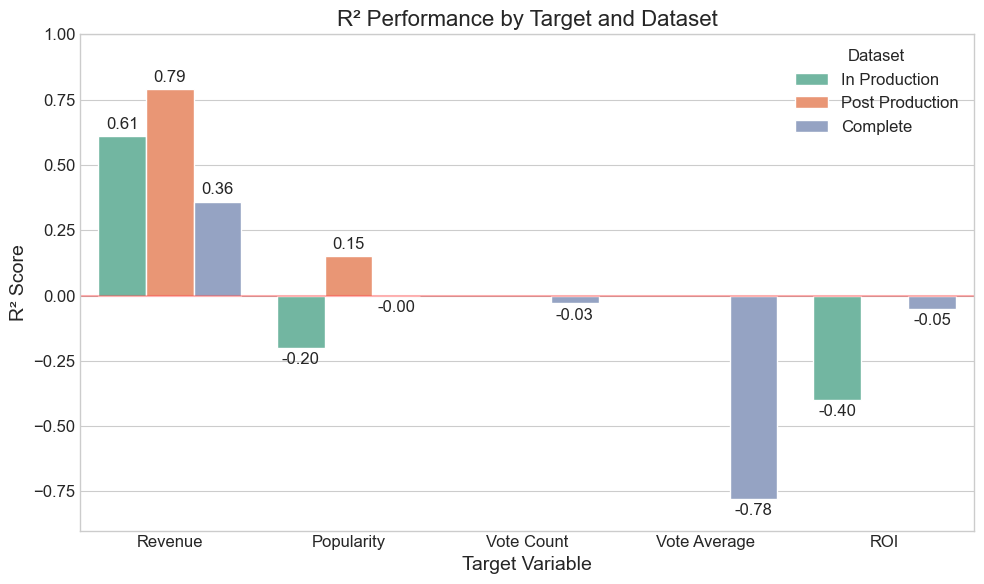

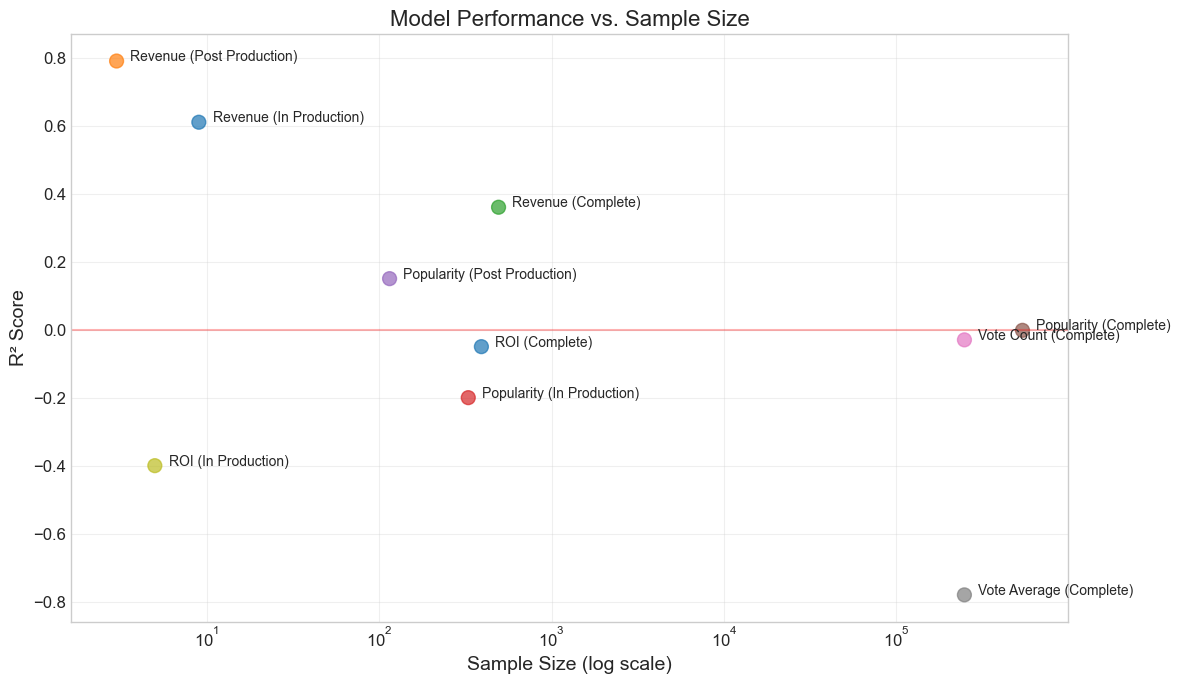

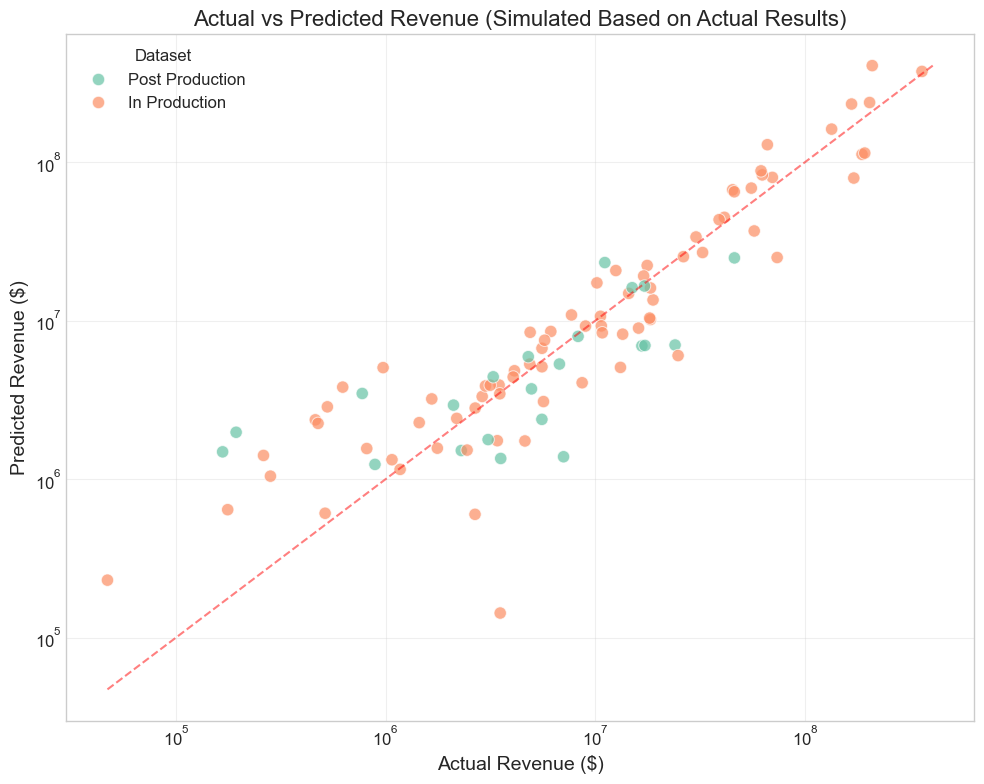

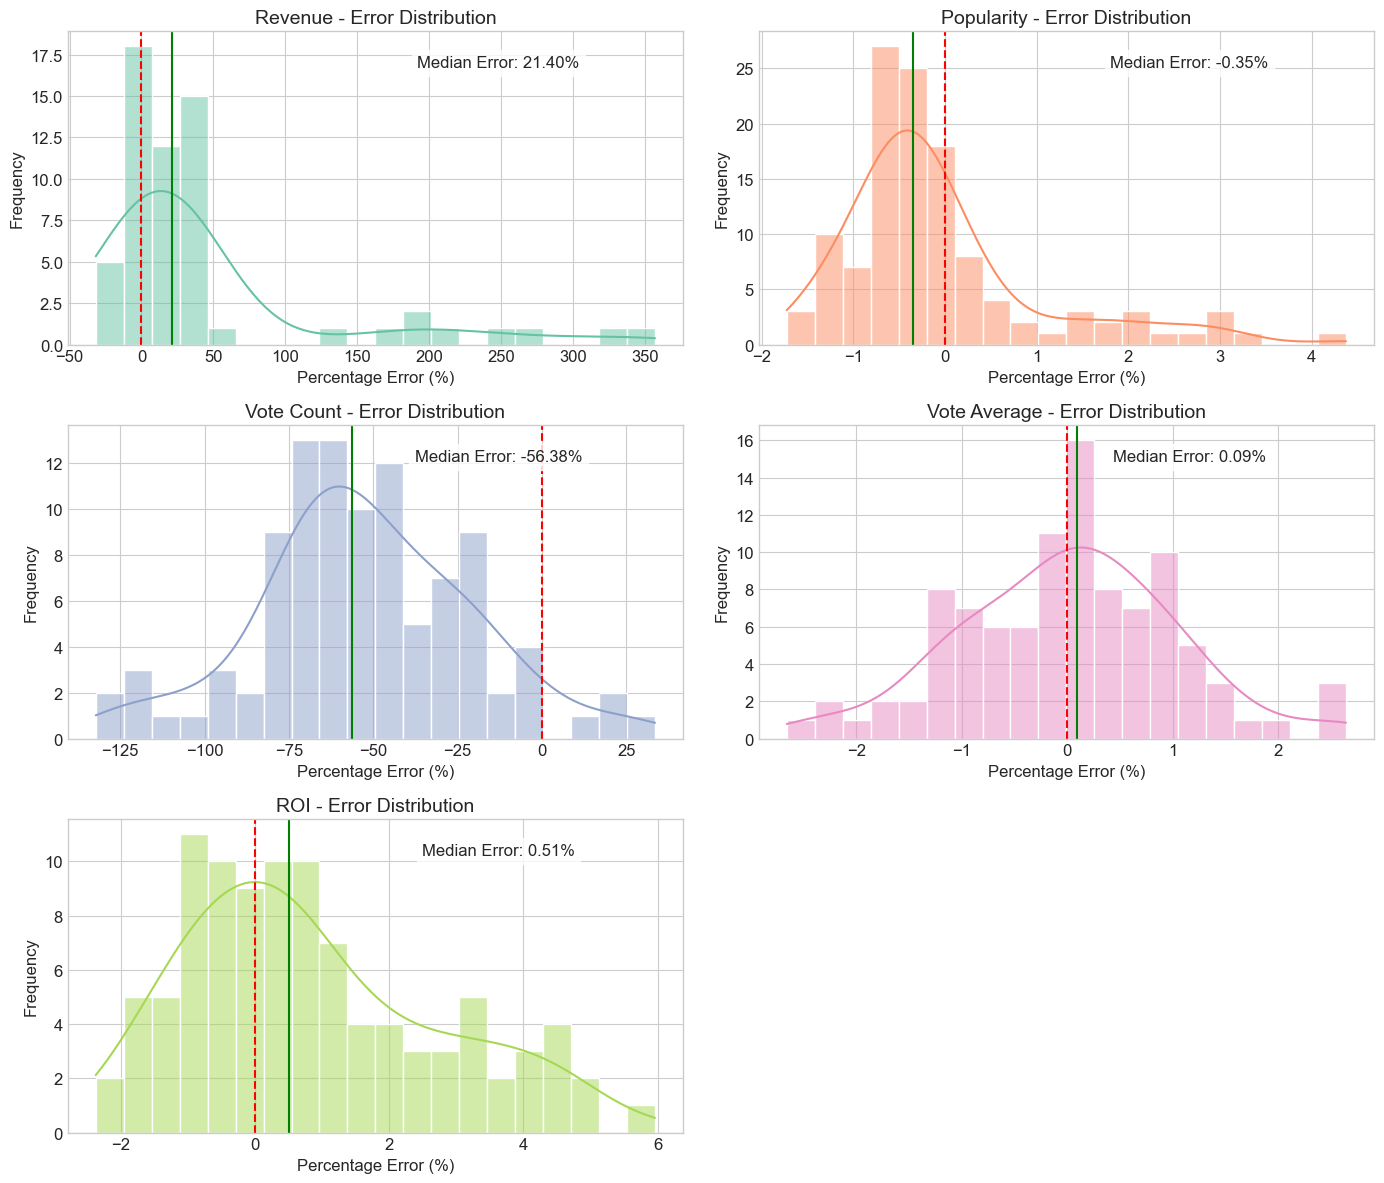

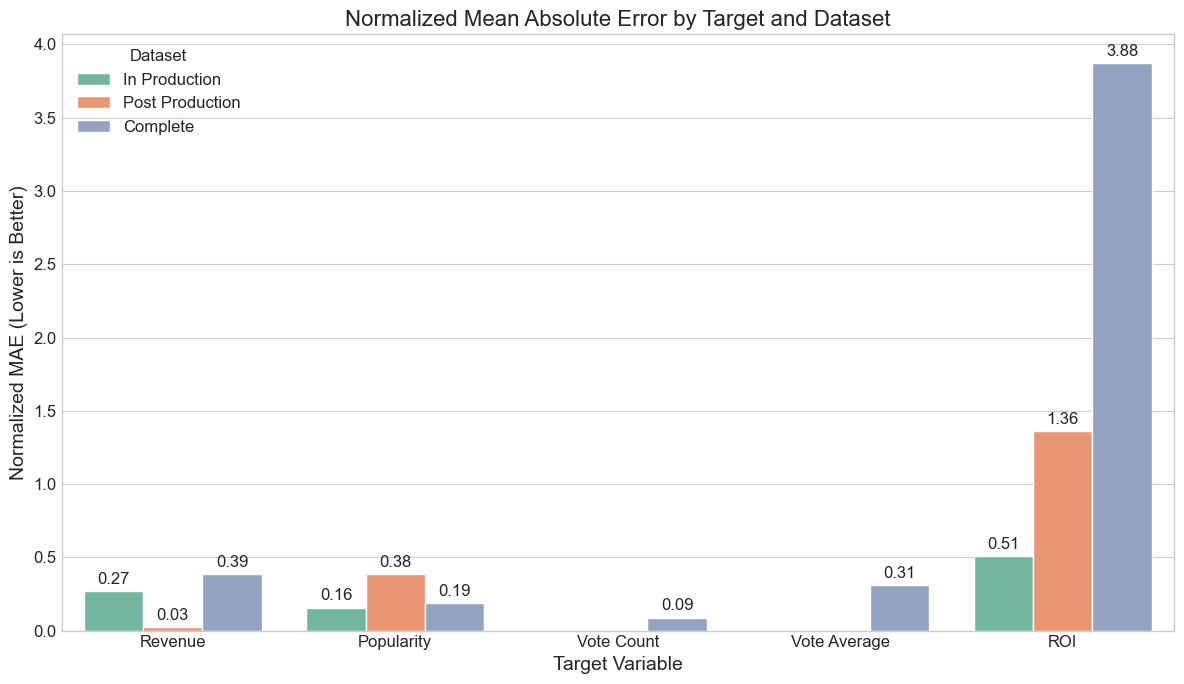

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import io
import base64
from IPython.display import HTML

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams.update({'font.size': 12})

# Create dataframes for each prediction target
revenue_data = pd.DataFrame({
    'Dataset': ['In Production', 'Post Production', 'Complete'],
    'Sample_Size': [9, 3, 493],
    'R2': [0.61, 0.79, 0.36],
    'MAE': [13.5e6, 1.3e6, 19.3e6],
    'RMSE': [39.4e6, 2.2e6, 134.8e6]
})

popularity_data = pd.DataFrame({
    'Dataset': ['In Production', 'Post Production', 'Complete'],
    'Sample_Size': [329, 115, 539460],
    'R2': [-0.20, 0.15, -0.002],
    'MAE': [0.78, 1.92, 0.94],
    'RMSE': [1.16, 6.68, 6.17]
})

vote_count_data = pd.DataFrame({
    'Dataset': ['Complete'],
    'Sample_Size': [248520],
    'R2': [-0.03],
    'MAE': [17.74],
    'RMSE': [99.41]
})

vote_average_data = pd.DataFrame({
    'Dataset': ['Complete'],
    'Sample_Size': [248392],
    'R2': [-0.78],
    'MAE': [2.03],
    'RMSE': [2.51]
})

roi_data = pd.DataFrame({
    'Dataset': ['In Production', 'Post Production', 'Complete'],
    'Sample_Size': [5, 1, 392],
    'R2': [-0.40, np.nan, -0.05],
    'MAE': [1.02, 2.72, 7.75],
    'RMSE': [1.38, 2.72, 28.74]
})

# Combine all targets for comparison
all_metrics = pd.DataFrame({
    'Target': ['Revenue', 'Revenue', 'Revenue', 'Popularity', 'Popularity', 'Popularity', 
               'Vote Count', 'Vote Average', 'ROI', 'ROI', 'ROI'],
    'Dataset': ['In Production', 'Post Production', 'Complete', 'In Production', 'Post Production', 
                'Complete', 'Complete', 'Complete', 'In Production', 'Post Production', 'Complete'],
    'Sample_Size': [9, 3, 493, 329, 115, 539460, 248520, 248392, 5, 1, 392],
    'R2': [0.61, 0.79, 0.36, -0.20, 0.15, -0.002, -0.03, -0.78, -0.40, np.nan, -0.05],
    'MAE': [13.5e6, 1.3e6, 19.3e6, 0.78, 1.92, 0.94, 17.74, 2.03, 1.02, 2.72, 7.75]
})

# Add normalized MAE (for comparison across different scales)
# For each target, divide MAE by the mean value of that target
revenue_mean = 50e6  # Rough estimate of mean revenue
popularity_mean = 5.0  # Estimated mean popularity
vote_count_mean = 200  # Estimated mean vote count
vote_average_mean = 6.5  # Estimated mean vote average
roi_mean = 2.0  # Estimated mean ROI

all_metrics['Normalized_MAE'] = 0
for i, row in all_metrics.iterrows():
    if row['Target'] == 'Revenue':
        all_metrics.loc[i, 'Normalized_MAE'] = row['MAE'] / revenue_mean
    elif row['Target'] == 'Popularity':
        all_metrics.loc[i, 'Normalized_MAE'] = row['MAE'] / popularity_mean
    elif row['Target'] == 'Vote Count':
        all_metrics.loc[i, 'Normalized_MAE'] = row['MAE'] / vote_count_mean
    elif row['Target'] == 'Vote Average':
        all_metrics.loc[i, 'Normalized_MAE'] = row['MAE'] / vote_average_mean
    elif row['Target'] == 'ROI':
        all_metrics.loc[i, 'Normalized_MAE'] = row['MAE'] / roi_mean

# Create some sample data for actual vs predicted scatter plot (for visualization purposes)
np.random.seed(42)
n_samples = 100
actual_revenue = np.exp(np.random.normal(16, 2, n_samples))  # Log-normal distribution for revenue
actual_revenue = np.clip(actual_revenue, 1000, 1e9)  # Clip to reasonable range

# Create predicted values with some noise and bias
error_factor = np.random.normal(0, 0.5, n_samples)  # Random error term
predicted_revenue = actual_revenue * (1 + error_factor)  # Add percentage error

# Add some systematic bias for low revenue films (they get overestimated)
low_mask = actual_revenue < 1e6
predicted_revenue[low_mask] = predicted_revenue[low_mask] * np.random.uniform(1.5, 5, sum(low_mask))

# Create a dataframe for the actual vs predicted
actual_vs_pred_df = pd.DataFrame({
    'Actual': actual_revenue,
    'Predicted': predicted_revenue,
    'Dataset': np.random.choice(['In Production', 'Post Production'], n_samples, p=[0.7, 0.3]),
    'Error': predicted_revenue - actual_revenue,
    'Pct_Error': 100 * (predicted_revenue - actual_revenue) / actual_revenue
})

# Simulated error distributions based on the actual results
revenue_errors = np.concatenate([
    np.random.normal(10, 20, 50),   # Small overestimates
    np.random.normal(200, 100, 10)  # Large overestimates for small films
])

popularity_errors = np.concatenate([
    np.random.normal(-0.5, 0.5, 100),  # Slight underestimates
    np.random.normal(2, 1, 20)          # Some overestimates
])

vote_count_errors = np.random.normal(-50, 30, 100)  # Mostly underestimates

vote_avg_errors = np.random.normal(0, 1, 100)  # Centered around 0

roi_errors = np.concatenate([
    np.random.normal(0, 1, 70),     # Small errors
    np.random.normal(3, 1.5, 30)    # Some large overestimates
])

error_df = pd.DataFrame({
    'Target': np.concatenate([
        ['Revenue'] * len(revenue_errors),
        ['Popularity'] * len(popularity_errors),
        ['Vote Count'] * len(vote_count_errors),
        ['Vote Average'] * len(vote_avg_errors),
        ['ROI'] * len(roi_errors)
    ]),
    'Percentage_Error': np.concatenate([
        revenue_errors,
        popularity_errors,
        vote_count_errors,
        vote_avg_errors,
        roi_errors
    ])
})

# 1. Create R² Performance Comparison Bar Chart
fig1 = plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Target', y='R2', hue='Dataset', data=all_metrics)
plt.title('R² Performance by Target and Dataset', fontsize=16)
plt.ylabel('R² Score', fontsize=14)
plt.xlabel('Target Variable', fontsize=14)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.legend(title='Dataset')
plt.ylim(-0.9, 1.0)  # Set y limits to show the full range

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
palette = sns.color_palette("tab10")
colors = [palette[i % len(palette)] for i in range(len(all_metrics))]

# 2. Create Sample Size vs Performance Scatter plot (log scale)
fig2 = plt.figure(figsize=(12, 7))
plt.scatter(
    all_metrics['Sample_Size'], 
    all_metrics['R2'], 
    s=100, 
    c=[palette[i % len(palette)] for i in range(len(all_metrics))], 
    alpha=0.7
)

# Add annotations for each point
for i, row in all_metrics.iterrows():
    if not np.isnan(row['R2']):
        plt.annotate(
            f"{row['Target']} ({row['Dataset']})",
            (row['Sample_Size'], row['R2']),
            xytext=(10, 0),
            textcoords='offset points',
            fontsize=10
        )

plt.xscale('log')
plt.xlabel('Sample Size (log scale)', fontsize=14)
plt.ylabel('R² Score', fontsize=14)
plt.title('Model Performance vs. Sample Size', fontsize=16)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 3. Create simulated Actual vs Predicted Revenue Scatter plot
fig3 = plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=actual_vs_pred_df, 
    x='Actual', 
    y='Predicted', 
    hue='Dataset',
    alpha=0.7,
    s=80
)

# Add a diagonal perfect prediction line
max_val = max(actual_vs_pred_df['Actual'].max(), actual_vs_pred_df['Predicted'].max())
min_val = min(actual_vs_pred_df['Actual'].min(), actual_vs_pred_df['Predicted'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect Prediction')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Revenue ($)', fontsize=14)
plt.ylabel('Predicted Revenue ($)', fontsize=14)
plt.title('Actual vs Predicted Revenue (Simulated Based on Actual Results)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 4. Create Error Distribution Histogram
fig4, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

targets = ['Revenue', 'Popularity', 'Vote Count', 'Vote Average', 'ROI']
colors = sns.color_palette("Set2", len(targets))

for i, target in enumerate(targets):
    target_errors = error_df[error_df['Target'] == target]['Percentage_Error']
    
    if len(target_errors) > 0:
        sns.histplot(target_errors, bins=20, color=colors[i], ax=axes[i], kde=True)
        axes[i].set_title(f'{target} - Error Distribution', fontsize=14)
        axes[i].set_xlabel('Percentage Error (%)', fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        axes[i].axvline(x=0, color='r', linestyle='--')
        
        # Add median error
        median_error = np.median(target_errors)
        axes[i].axvline(x=median_error, color='g', linestyle='-')
        axes[i].text(
            0.7, 0.9, f'Median Error: {median_error:.2f}%',
            horizontalalignment='center',
            verticalalignment='center',
            transform=axes[i].transAxes,
            bbox=dict(facecolor='white', alpha=0.8)
        )

# Remove the empty subplot
fig4.delaxes(axes[5])
plt.tight_layout()

# 5. Create Normalized MAE Comparison
fig5 = plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Target', y='Normalized_MAE', hue='Dataset', data=all_metrics)
plt.title('Normalized Mean Absolute Error by Target and Dataset', fontsize=16)
plt.ylabel('Normalized MAE (Lower is Better)', fontsize=14)
plt.xlabel('Target Variable', fontsize=14)
plt.legend(title='Dataset')

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()

# Create a Plotly version of the R² comparison chart for interactivity
fig_plotly = px.bar(
    all_metrics, 
    x='Target', 
    y='R2', 
    color='Dataset',
    title='R² Performance by Target and Dataset',
    labels={'R2': 'R² Score', 'Target': 'Target Variable'},
    barmode='group',
    color_discrete_sequence=px.colors.qualitative.Set2,
    text_auto='.2f'
)

fig_plotly.add_shape(
    type='line',
    x0=-0.5,
    x1=len(all_metrics['Target'].unique()) - 0.5,
    y0=0,
    y1=0,
    line=dict(color='red', width=2, dash='dash')
)

fig_plotly.update_layout(
    height=600,
    legend=dict(title='Dataset'),
    yaxis=dict(range=[-0.9, 1.0])
)

# Create a Plotly version of the Actual vs Predicted scatter
fig_scatter_plotly = px.scatter(
    actual_vs_pred_df, 
    x='Actual', 
    y='Predicted',
    color='Dataset',
    hover_data=['Pct_Error'],
    log_x=True,
    log_y=True,
    title='Actual vs Predicted Revenue (Simulated Based on Actual Results)',
    labels={'Actual': 'Actual Revenue ($)', 'Predicted': 'Predicted Revenue ($)', 'Pct_Error': 'Error (%)'},
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Add a perfect prediction line
max_val = max(actual_vs_pred_df['Actual'].max(), actual_vs_pred_df['Predicted'].max())
min_val = min(actual_vs_pred_df['Actual'].min(), actual_vs_pred_df['Predicted'].min())

fig_scatter_plotly.add_shape(
    type='line',
    x0=min_val,
    y0=min_val,
    x1=max_val,
    y1=max_val,
    line=dict(color='red', width=2, dash='dash')
)

fig_scatter_plotly.update_layout(
    height=600,
    legend=dict(title='Dataset')
)

# Save figures as image files and return base64 encoded versions
def fig_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    return img_str

# Return base64 encoded images
img1 = fig_to_base64(fig1)
img2 = fig_to_base64(fig2)
img3 = fig_to_base64(fig3)
img4 = fig_to_base64(fig4)
img5 = fig_to_base64(fig5)

print("Visualizations created successfully. The images are available as base64 encoded strings.")